# Setting environment

In [1]:
import os
import gc
import csv
import zipfile
from urllib.request import urlretrieve
from IPython.display import display, HTML

import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt

%matplotlib inline

rc = {"font.family": "Arial",
      "font.size": 16,        
      "axes.labelsize": 16,
      "axes.titlesize": 16,
      "legend.fontsize": 14, 
      "xtick.labelsize": 14, 
      "ytick.labelsize": 14}


def my_colors(n=5):
    return [(sns.color_palette("viridis", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]
def my_colors_r(n=5):
    return [(sns.color_palette("viridis_r", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]

sns.set(font="Arial", rc=rc, palette=my_colors())
sns.set_style("ticks", {"axes.edgecolor": "k", 
                        "axes.linewidth": 0.8, 
                        "axes.grid": False,
                        "xtick.major.width": 0.8, 
                        "ytick.major.width": 0.8})

# Data Import

In [2]:
PATH = os.getcwd()
PATH += "\\Projet7\\"

print(PATH)
print(os.listdir(PATH))

C:\Users\glass\Projet7\
['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [3]:
f = PATH+'application_train.csv'

with open(f, 'r') as csvfile:  # Sniffing csv to find separator
    dialect = csv.Sniffer().sniff(csvfile.readline())
    sep = dialect.delimiter

df = pd.read_csv(f,
                 sep=sep,
                 low_memory=False,
                 verbose=False,
                 encoding='ISO-8859-1',
                 dtype={'Special': 'object'}
                 )

In [4]:
f = PATH+'HomeCredit_columns_description.csv'
DESCRIPTOR = pd.read_csv(f, sep=sep, encoding='ISO-8859-1')
display(HTML(DESCRIPTOR.to_html()))

# Data form

df shape = (307511, 122)
NaN rate over whole df = 24%
df duplicates rate = 0%


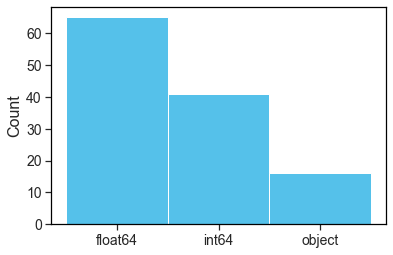

In [5]:
print(f'df shape = {df.shape}')
print(f'NaN rate over whole df = {df.isna().sum().sum()/df.size:.0%}')
print(f'df duplicates rate = {(len(df)-len(df.drop_duplicates()))/len(df):.0%}')

sns.histplot(df.dtypes.astype('string').sort_values(), color = '#1CADE4');
plt.show()

display(HTML(df.head(5).T.to_html()))

# missing values

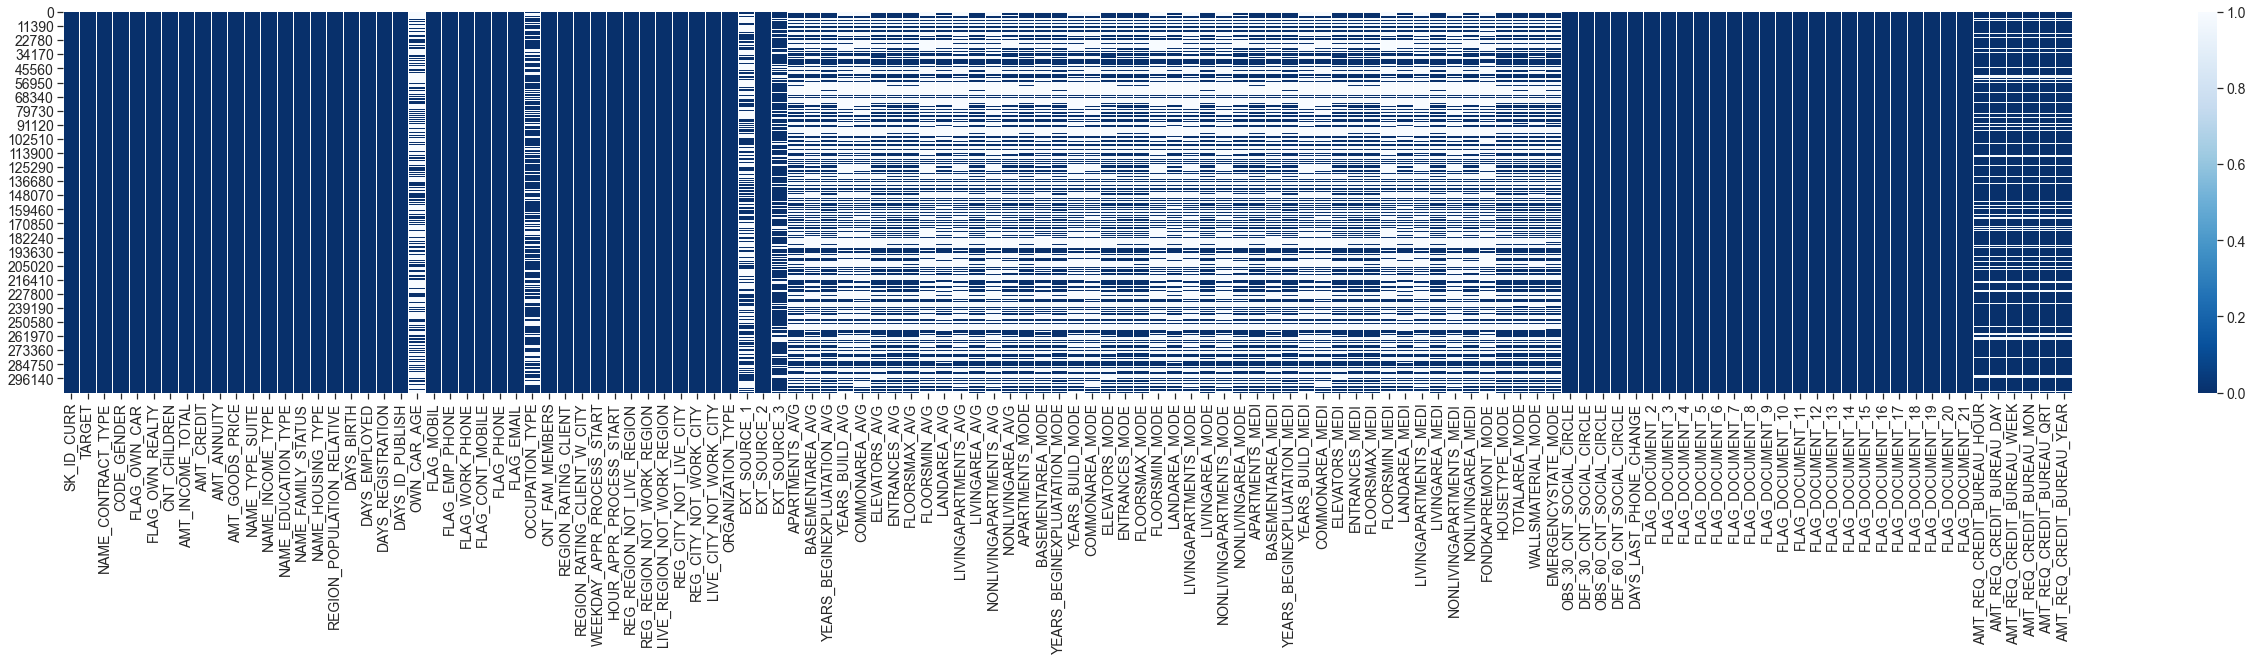

In [6]:
plt.figure(figsize=(45, 7))
sns.heatmap(df.isna(), cmap="Blues_r")
plt.show();

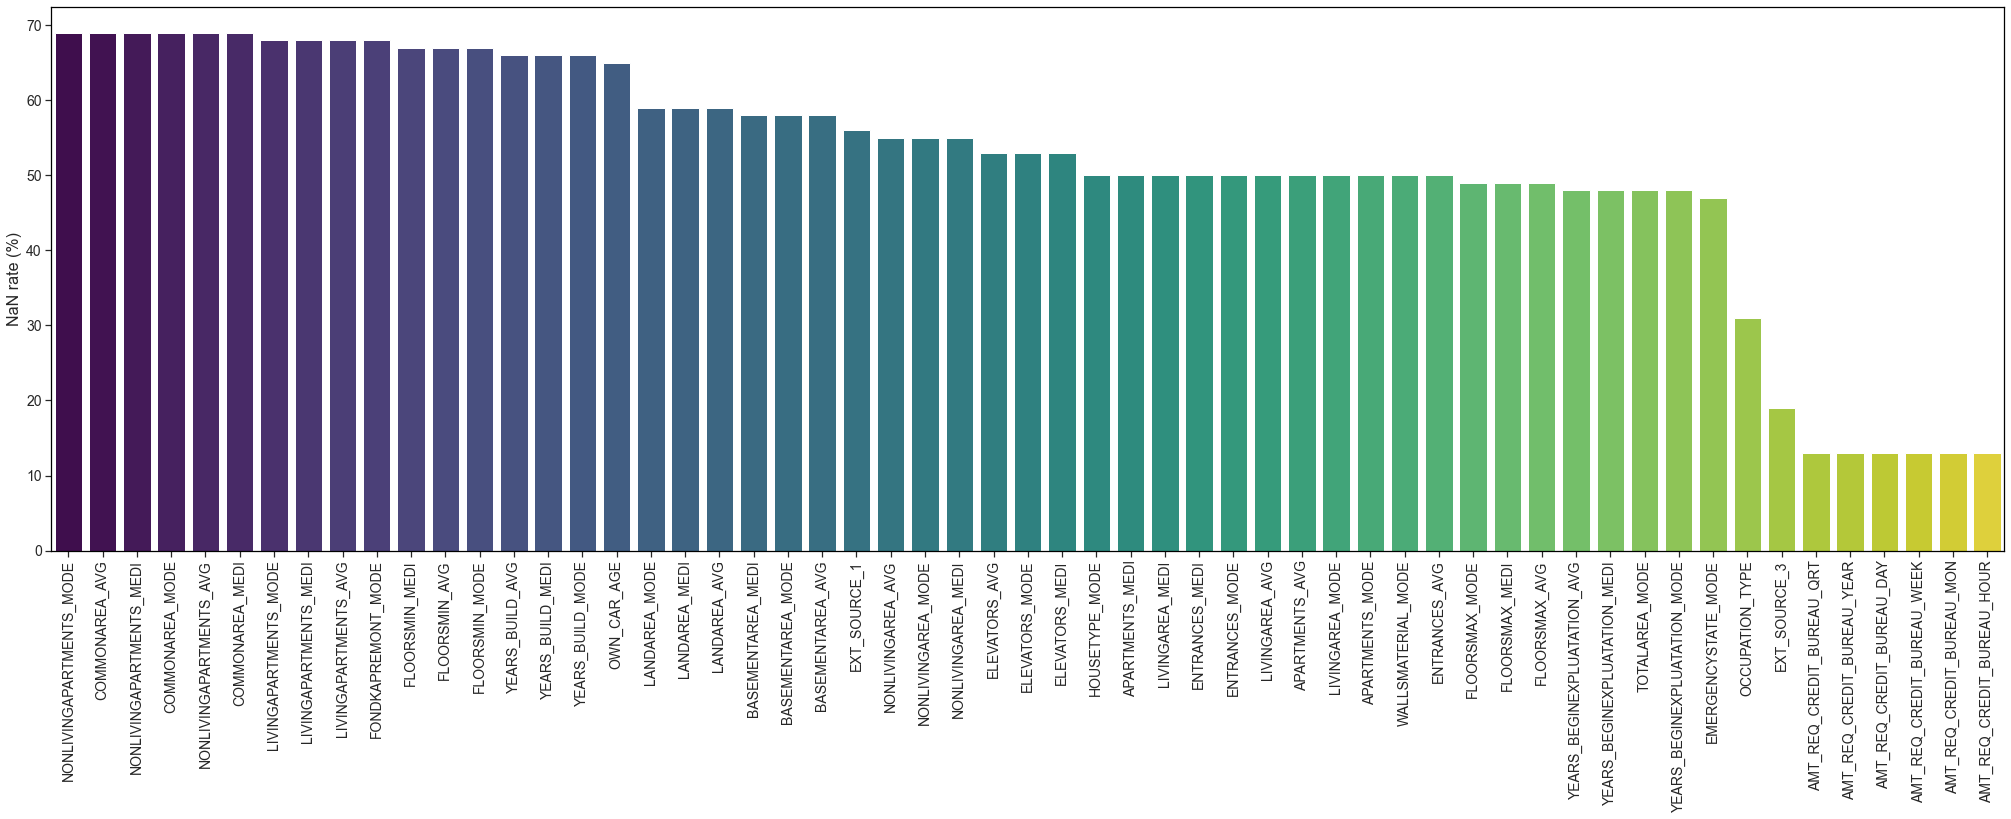

In [7]:

is_nan = (100*df.isna().sum()/len(df)).astype('int').sort_values(ascending=False)
is_nan = is_nan[is_nan > 0]

plt.figure(figsize=(35,10))
sns.barplot(x=is_nan.index, y=is_nan, palette=my_colors(len(is_nan)))
plt.xticks(rotation = 90)
plt.ylabel('NaN rate (%)');

In [8]:
df_unpay = df[df.TARGET == 1]
df_pay = df[df.TARGET == 0]

In [9]:
df_unpay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24825 entries, 0 to 307509
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 23.3+ MB


In [10]:
df_pay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282686 entries, 1 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 265.3+ MB


# Exploratory Data Analysis

Target analysis
Unpayable represents 10% of payable. The classes are very imbalanced. We'll handle that later.

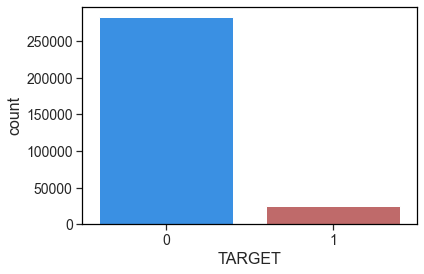

In [11]:
color_bg = ['dodgerblue', 'indianred']
sns.countplot(x=df.TARGET, palette=color_bg);


Target/num var relationships
Gathering and ploting distribution of all numerical features within target classes (boxplots).

In [12]:

num_col = df.select_dtypes(np.number).columns.to_list()
num_col.remove('TARGET')
len(num_col)

105

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


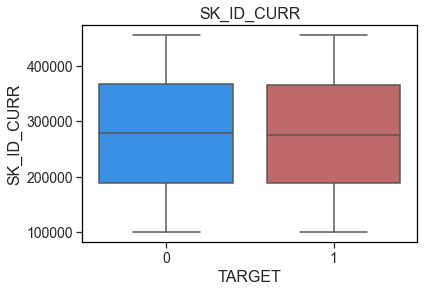

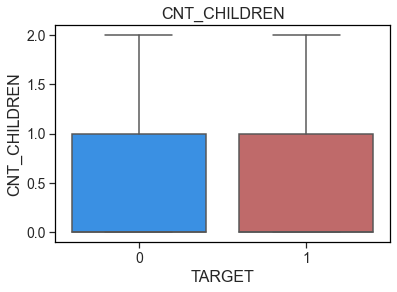

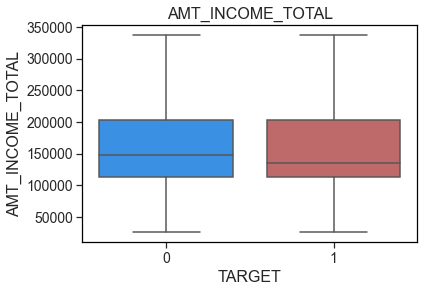

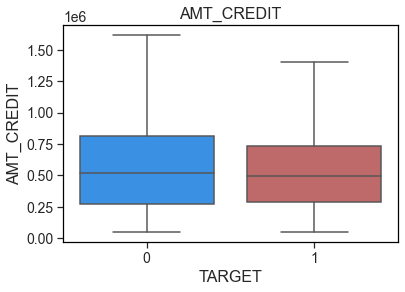

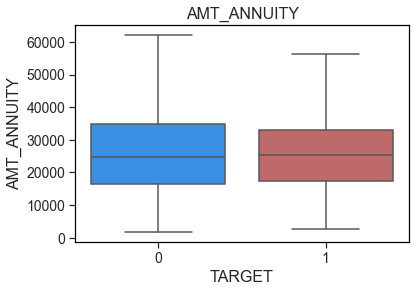

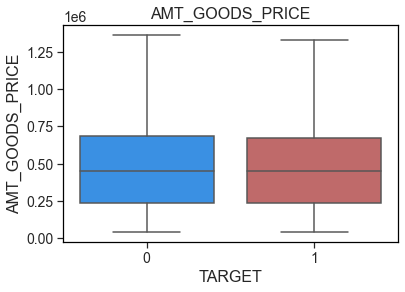

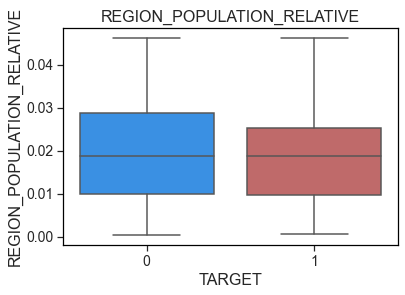

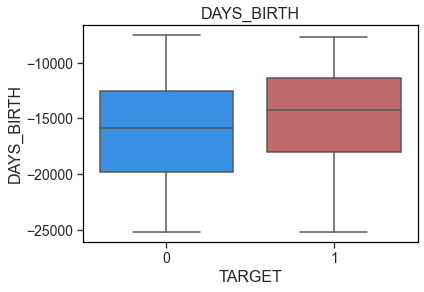

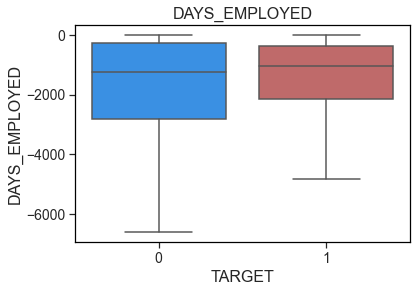

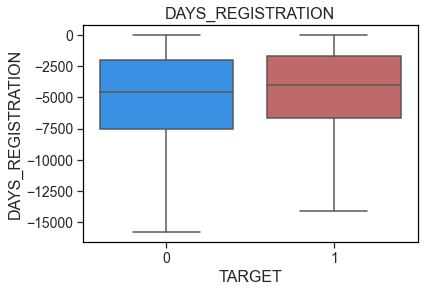

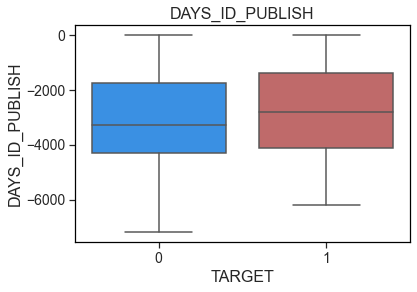

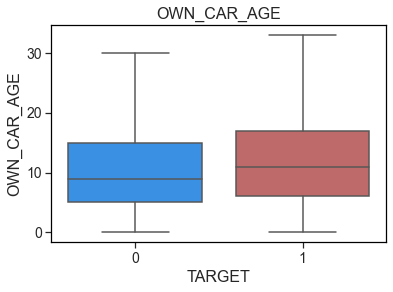

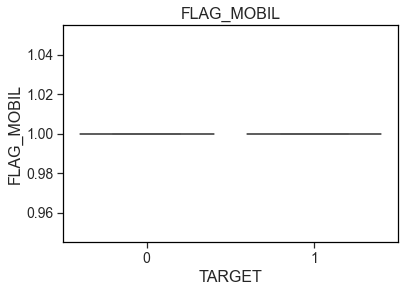

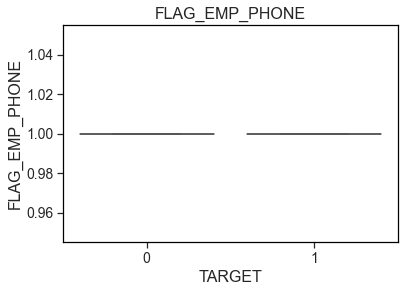

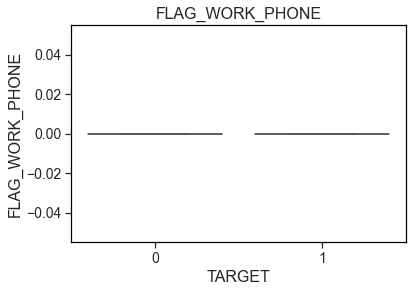

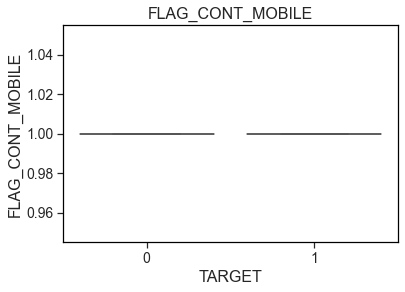

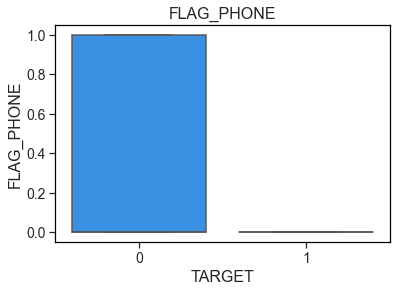

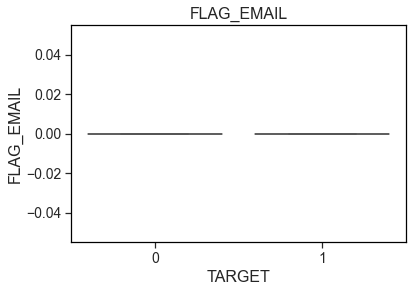

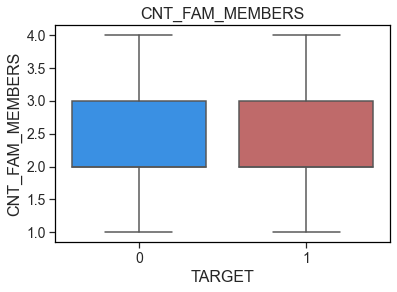

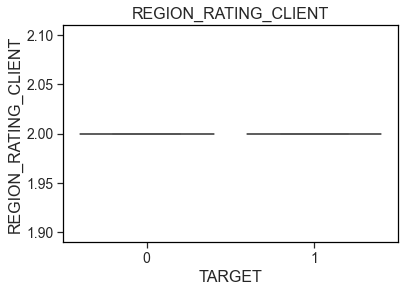

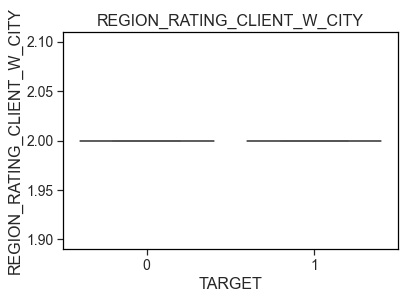

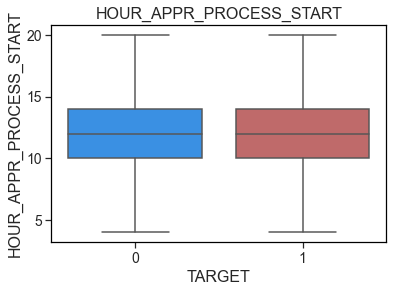

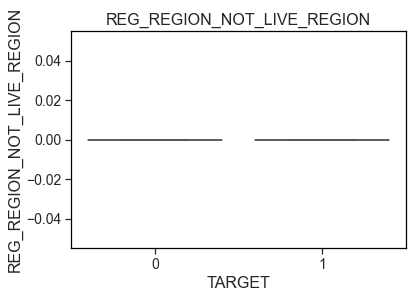

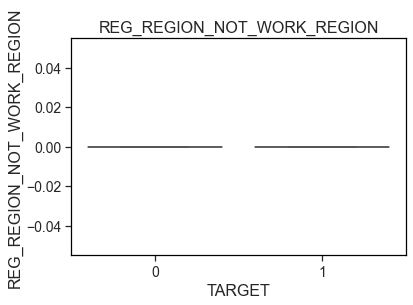

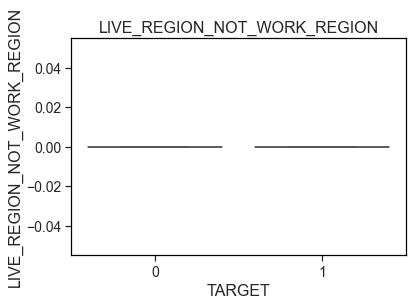

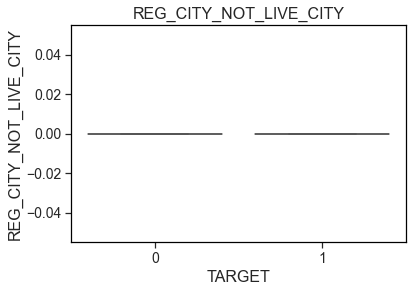

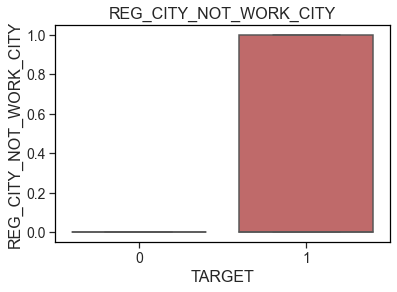

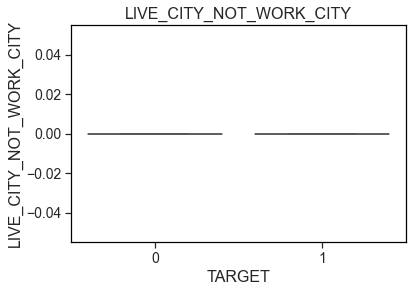

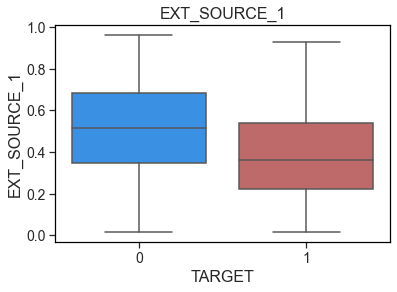

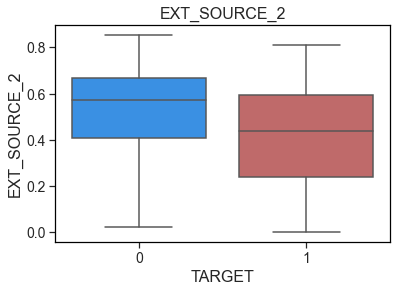

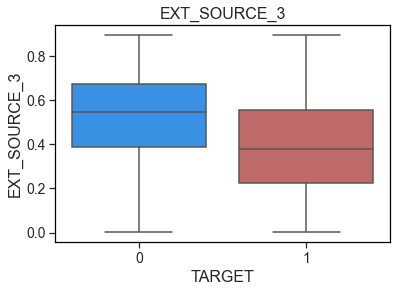

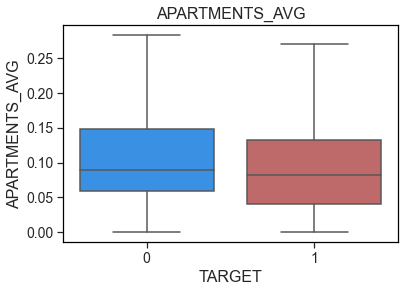

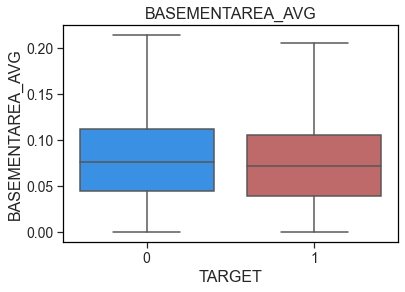

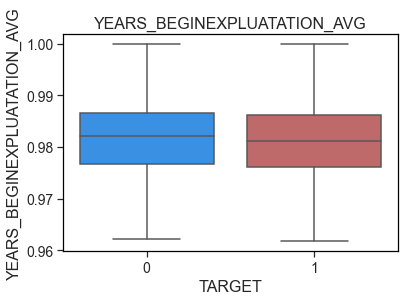

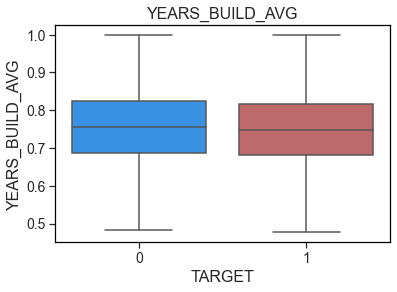

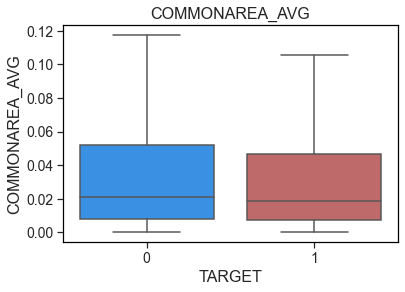

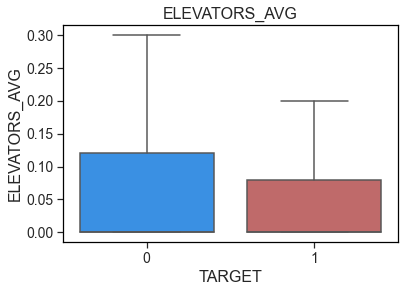

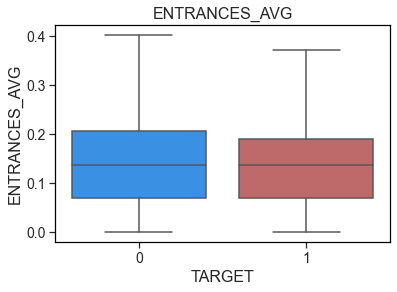

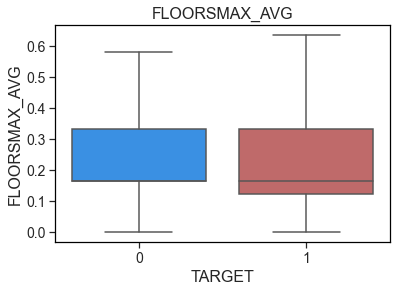

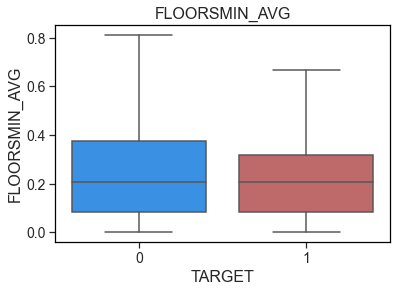

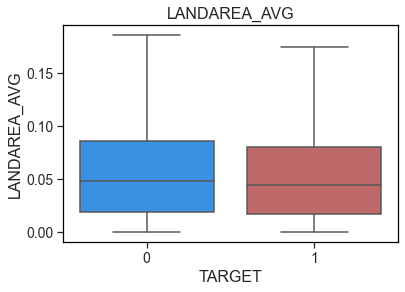

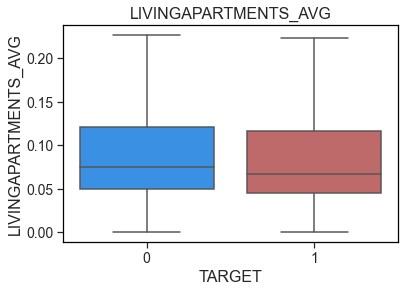

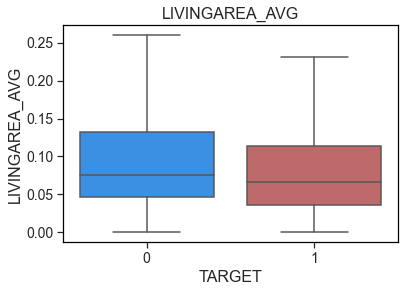

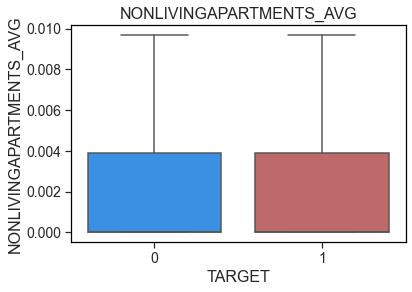

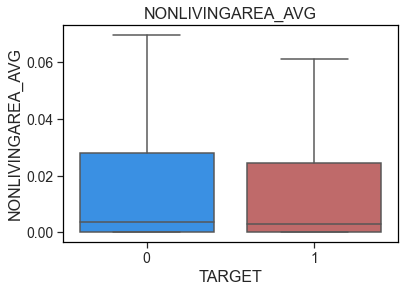

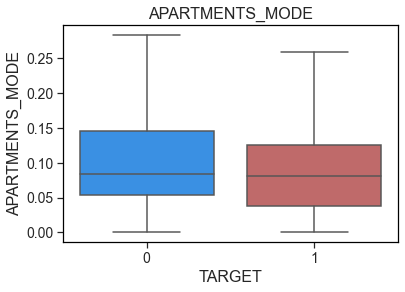

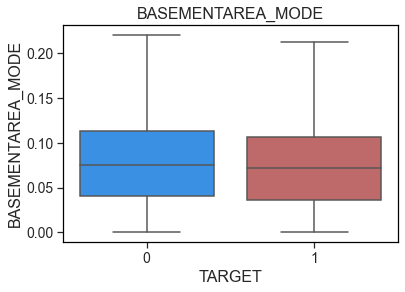

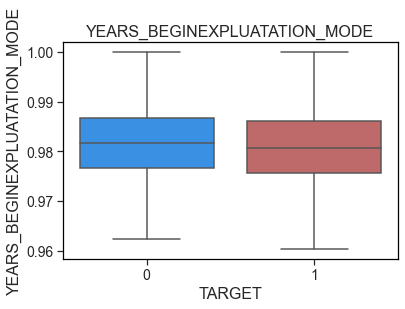

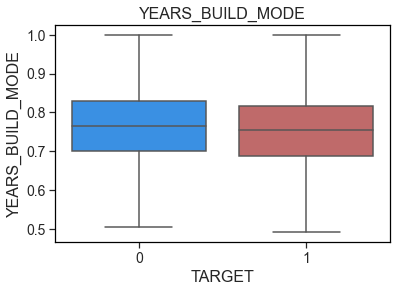

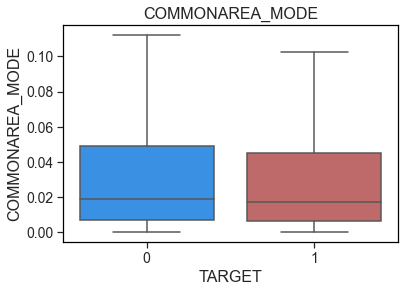

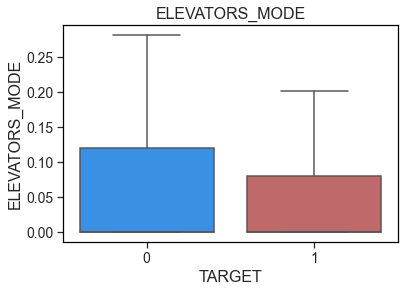

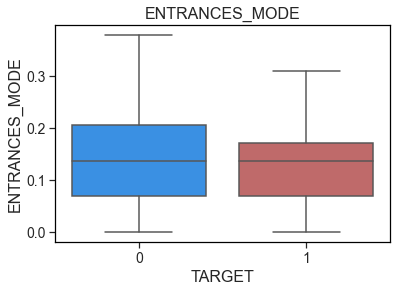

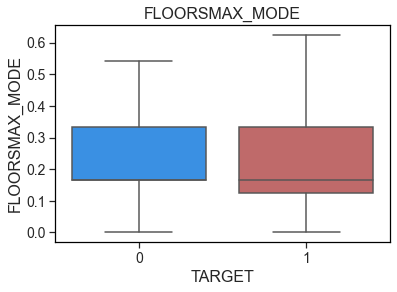

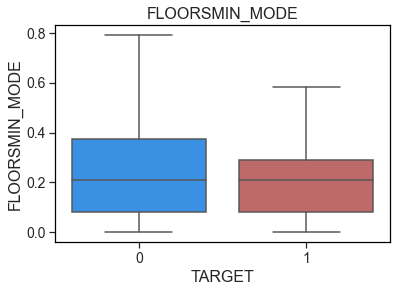

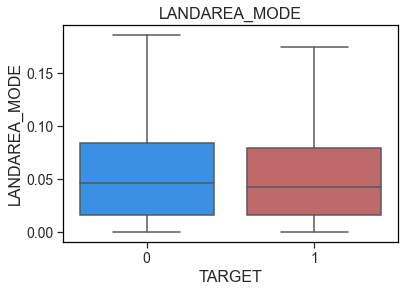

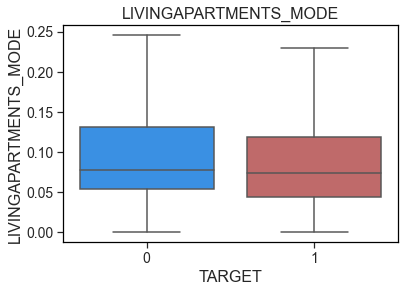

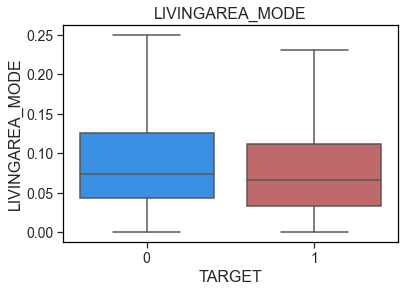

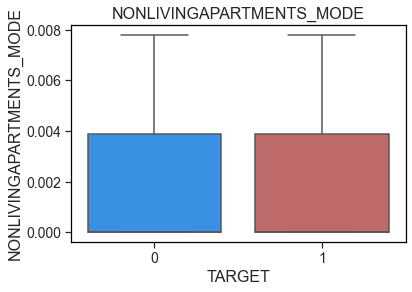

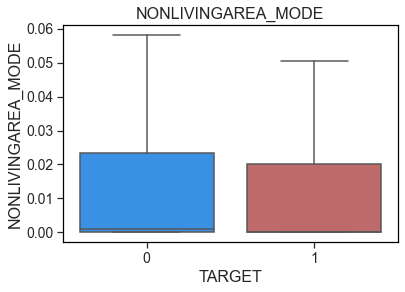

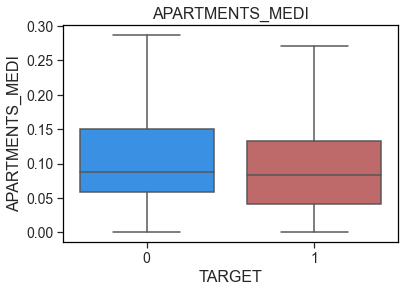

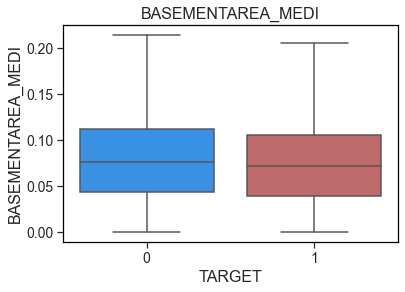

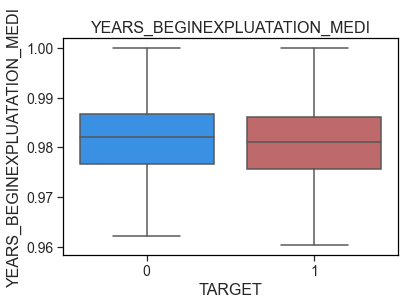

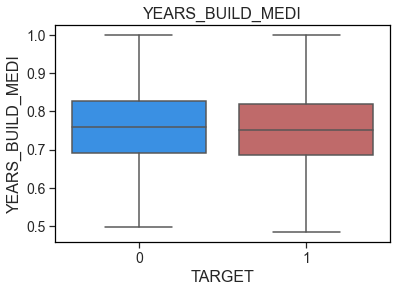

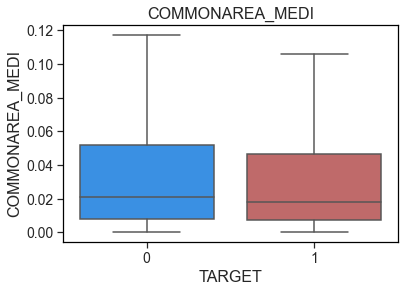

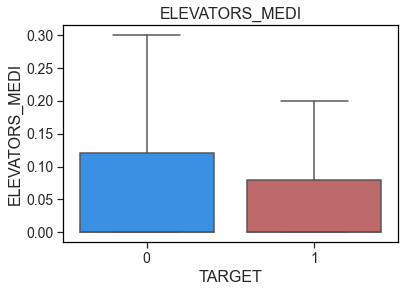

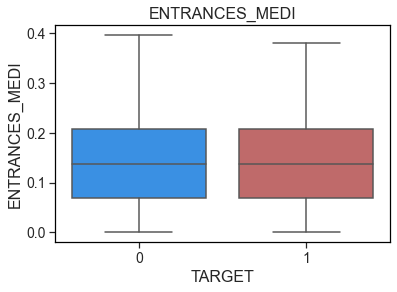

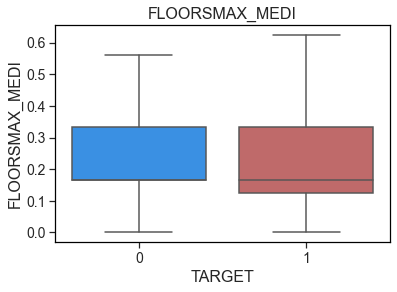

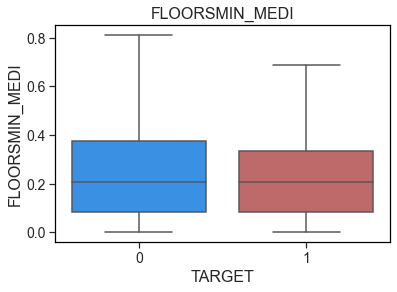

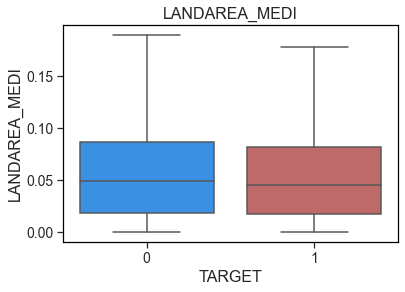

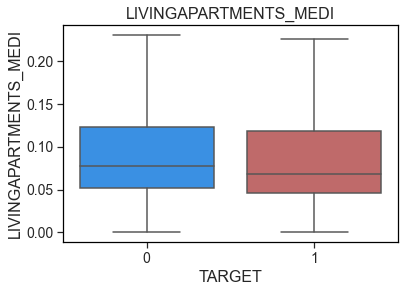

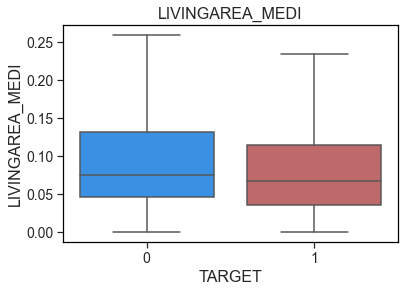

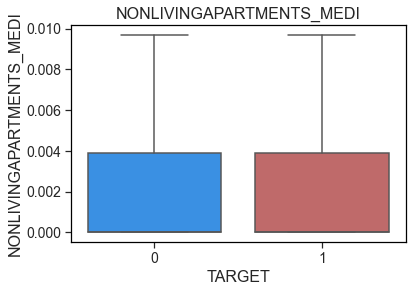

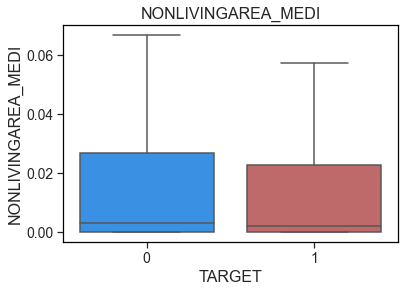

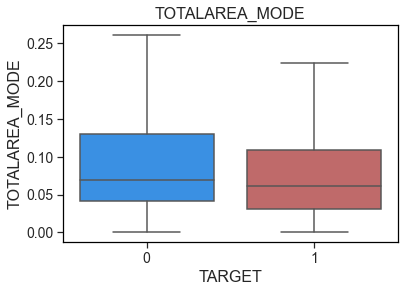

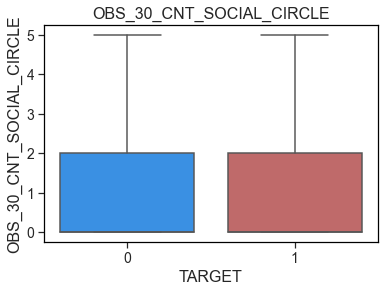

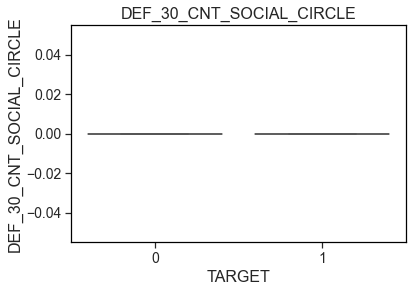

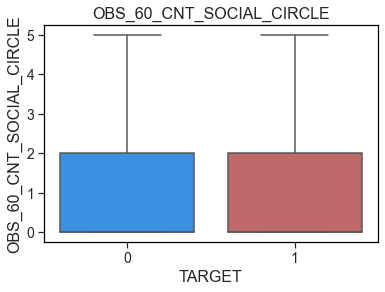

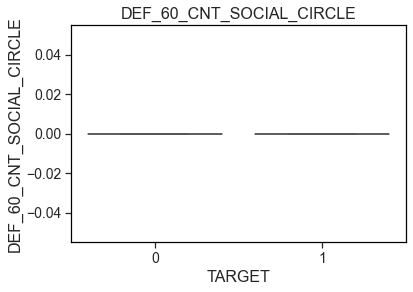

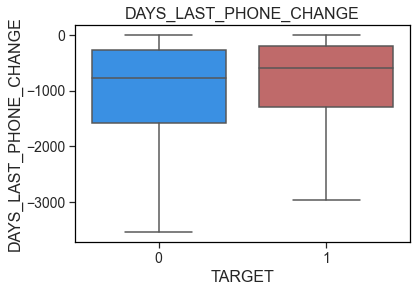

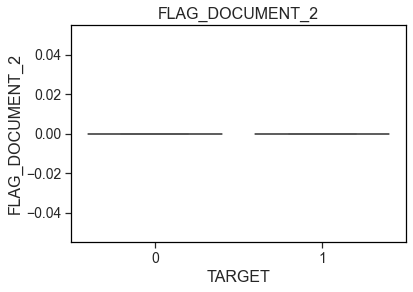

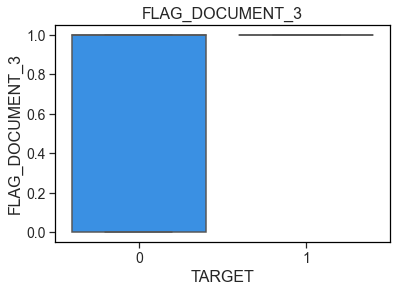

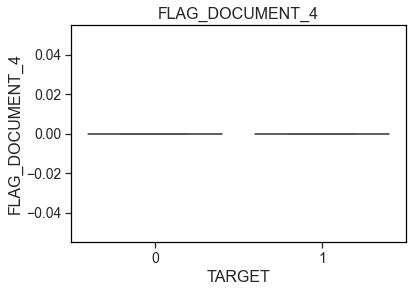

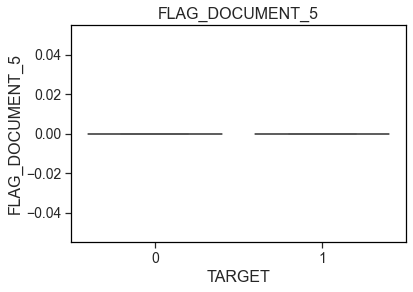

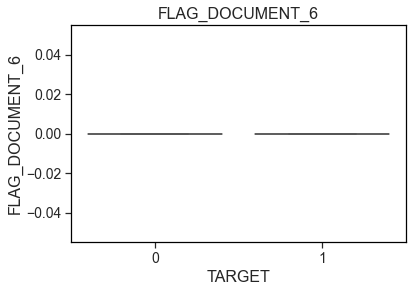

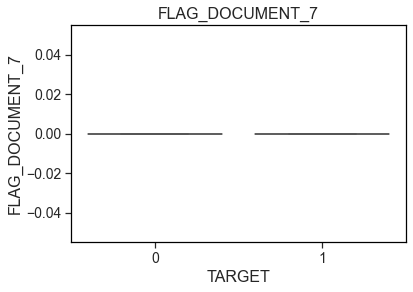

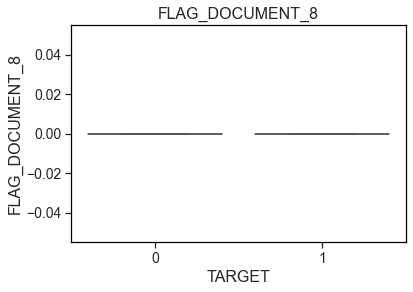

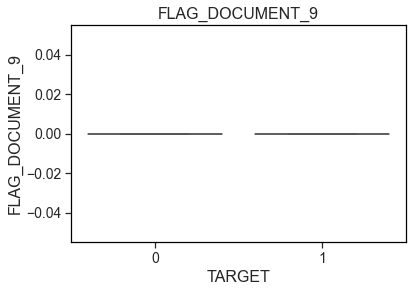

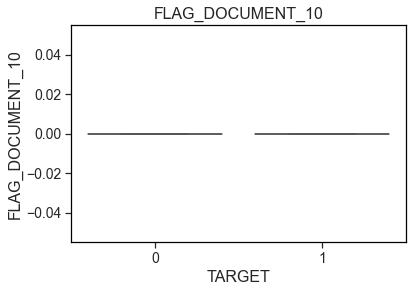

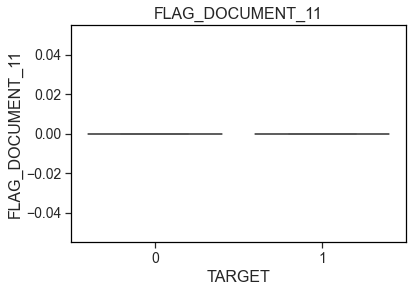

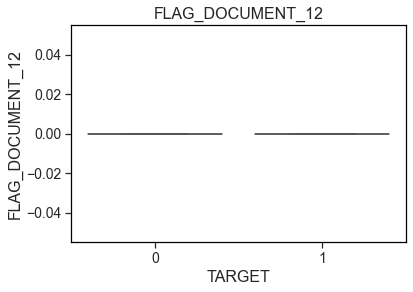

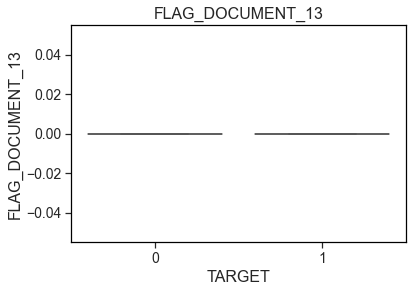

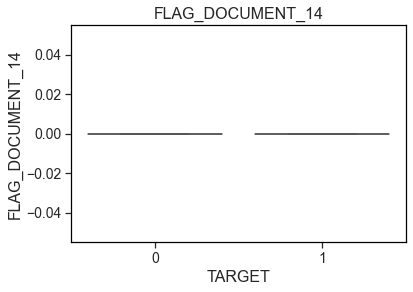

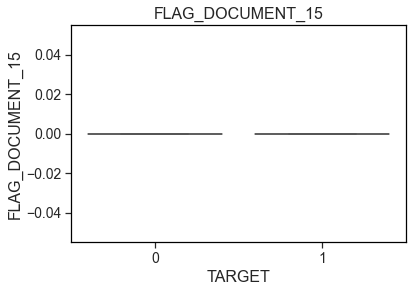

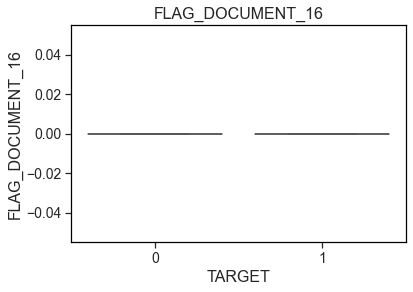

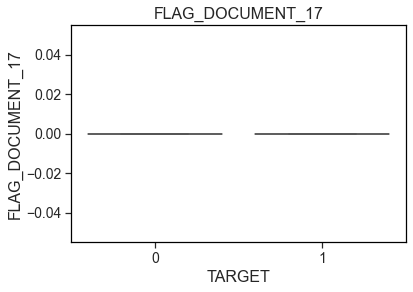

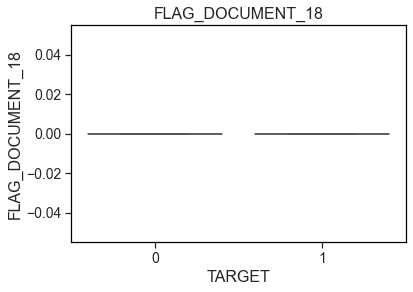

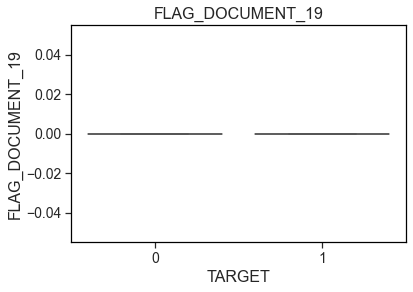

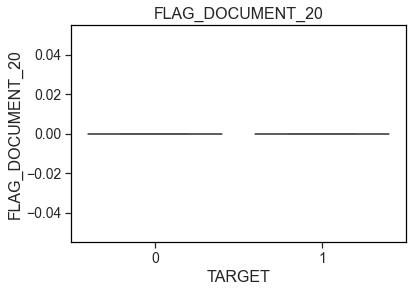

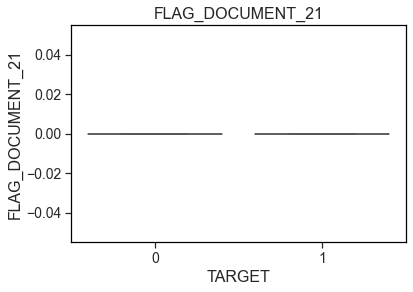

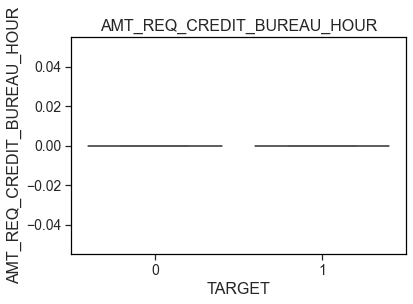

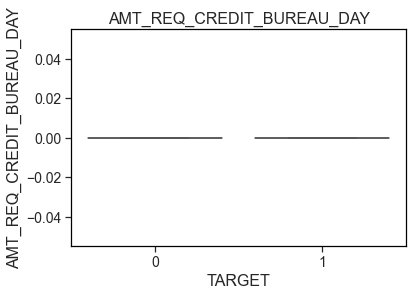

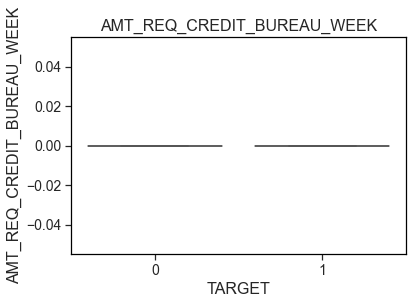

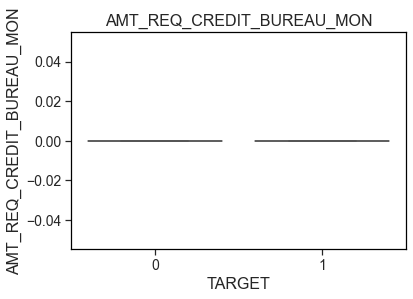

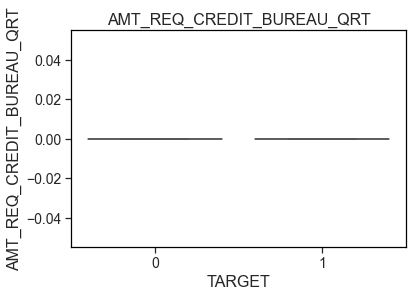

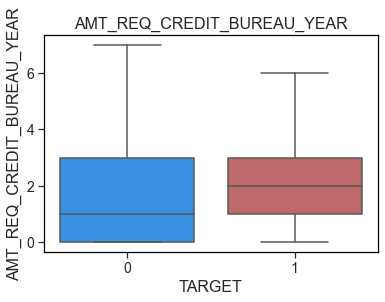

In [14]:
for col in num_col:
    sns.boxplot(data=df,
                  x='TARGET',
                  y=col,
                  showfliers=False,
                  palette=color_bg)
    plt.title(col)
    plt.show()

Now, let's gather all num features which pos and neg means is higher than ± 15%. This allows to having a first sight of interesting features having supposed significant distribution in pos and neg classes.

In [15]:
interest_col = []

for col in num_col:
    if ((df_unpay[col].mean()/df_pay[col].mean() < 0.85)\
        or (df_unpay[col].mean()/df_pay[col].mean() > 1.15))\
    and (df[col].nunique() > 2):
        ratio = df_unpay[col].mean()/df_pay[col].mean()
        std = df_unpay[col].std()/df_pay[col].std()
        interest_col.append(col)
        print(f'{col :_<30} Ratio of means unpay/pay: {ratio:.0%} (std ratio = {std:.0%})')

DAYS_EMPLOYED_________________ Ratio of means unpay/pay: 65% (std ratio = 84%)
EXT_SOURCE_1__________________ Ratio of means unpay/pay: 76% (std ratio = 98%)
EXT_SOURCE_2__________________ Ratio of means unpay/pay: 79% (std ratio = 114%)
EXT_SOURCE_3__________________ Ratio of means unpay/pay: 75% (std ratio = 108%)
ELEVATORS_AVG_________________ Ratio of means unpay/pay: 77% (std ratio = 88%)
ELEVATORS_MODE________________ Ratio of means unpay/pay: 78% (std ratio = 88%)
ELEVATORS_MEDI________________ Ratio of means unpay/pay: 77% (std ratio = 88%)
DEF_30_CNT_SOCIAL_CIRCLE______ Ratio of means unpay/pay: 138% (std ratio = 117%)
DEF_60_CNT_SOCIAL_CIRCLE______ Ratio of means unpay/pay: 143% (std ratio = 120%)
DAYS_LAST_PHONE_CHANGE________ Ratio of means unpay/pay: 83% (std ratio = 91%)
AMT_REQ_CREDIT_BUREAU_DAY_____ Ratio of means unpay/pay: 116% (std ratio = 96%)
AMT_REQ_CREDIT_BUREAU_MON_____ Ratio of means unpay/pay: 84% (std ratio = 80%)



Plotting KDE distributions of these interesting features (for better readibility rather than pristing histograms).

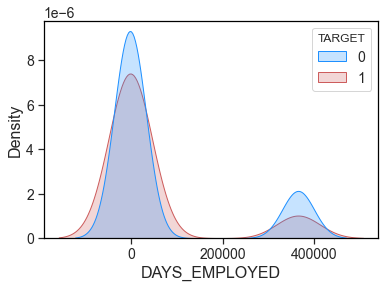

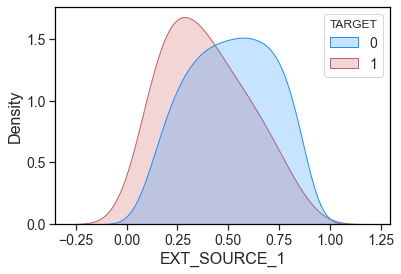

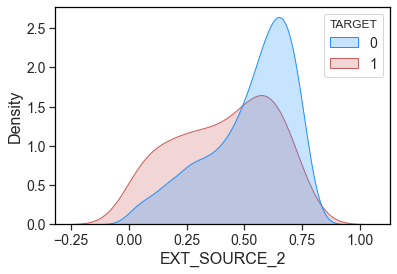

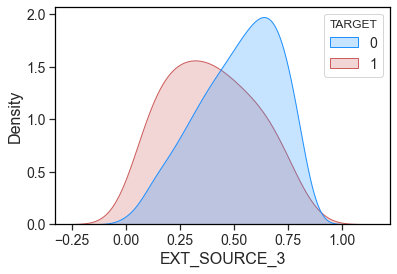

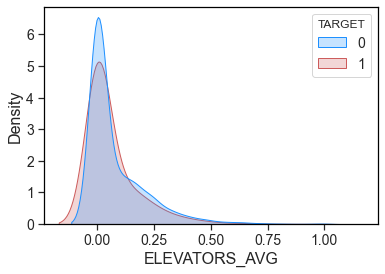

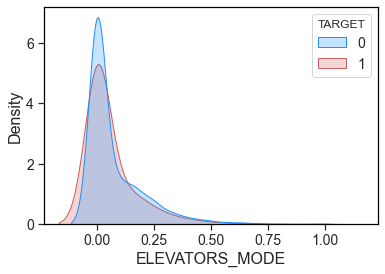

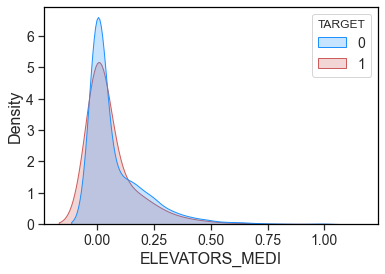

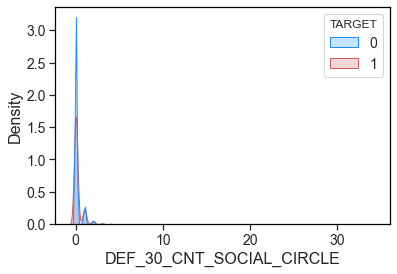

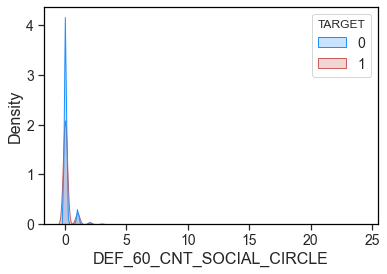

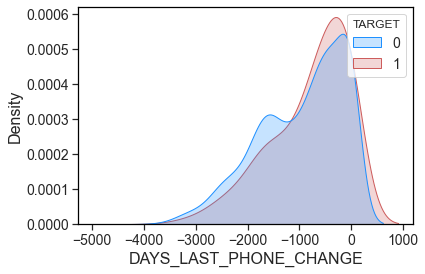

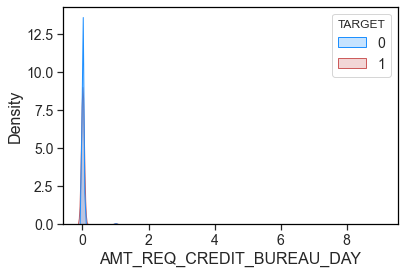

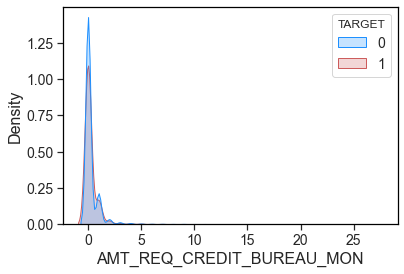

In [16]:

for col in interest_col:
    sns.kdeplot(data=df, x=col, hue='TARGET', bw_adjust=3,
                common_norm=False, fill=True, palette=color_bg)
    plt.show()

EXT_SOURCE_1 ,2 ,3 are very interesting, pity that we have not infos on their signification...


### Target/cat var relationships
Gathering categorical features and ploting crosstabs along with target.

In [17]:
cat_col = df.select_dtypes(exclude=np.number).columns

In [18]:
df[cat_col].nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

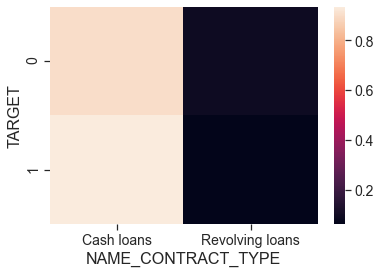

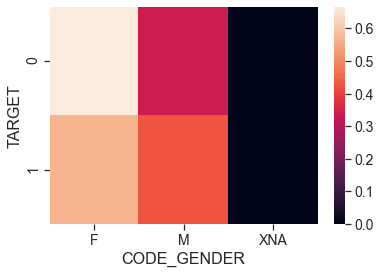

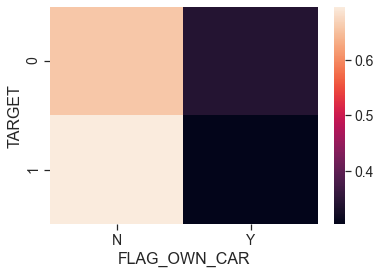

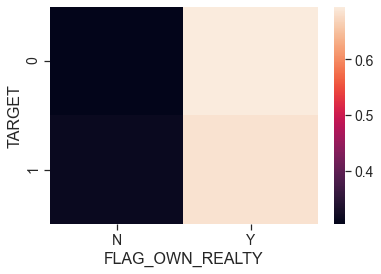

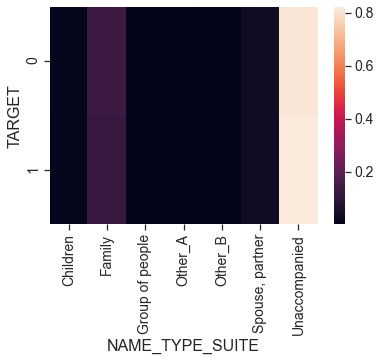

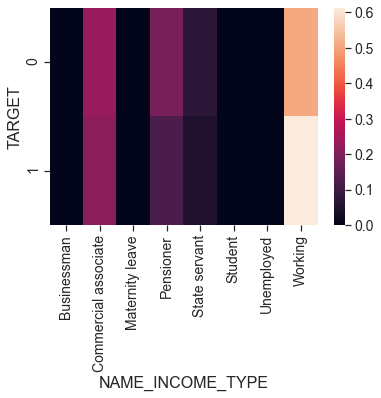

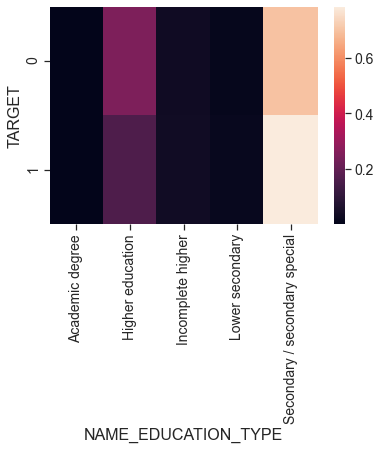

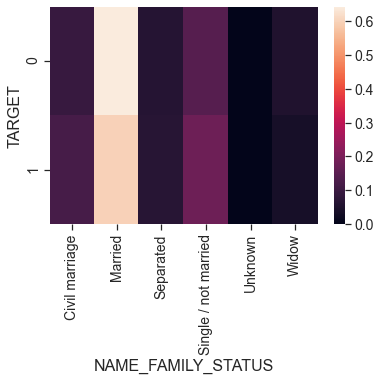

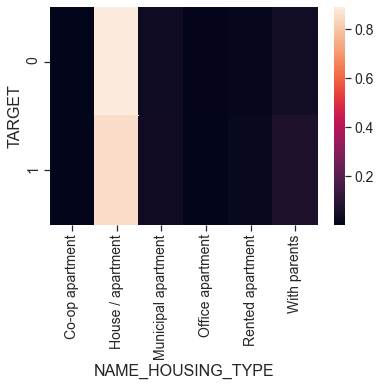

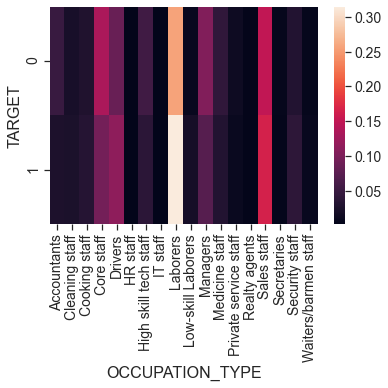

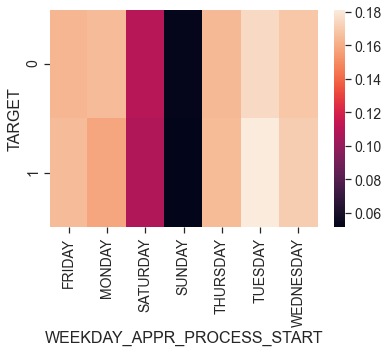

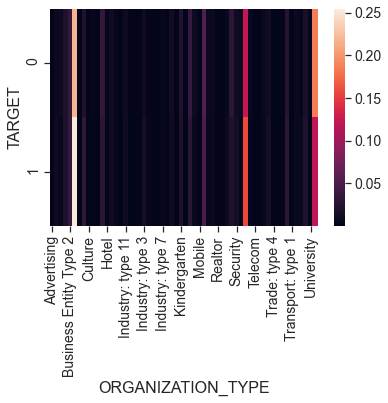

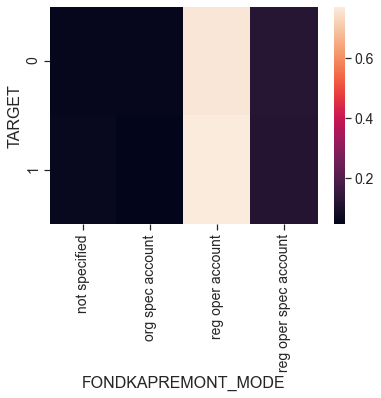

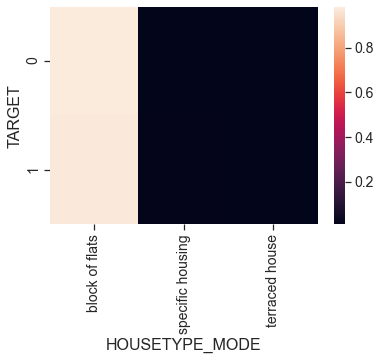

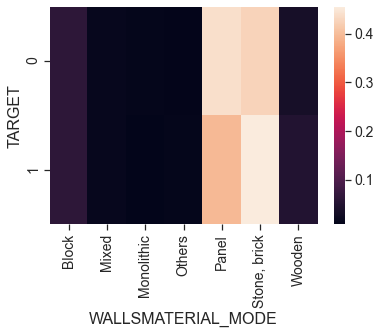

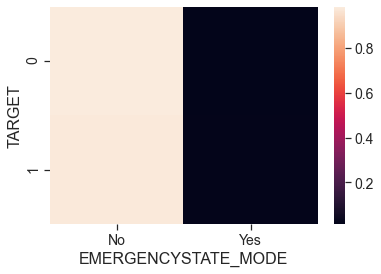

In [19]:
for col in cat_col:
    x_tab = pd.crosstab(df['TARGET'], df[col])
    x_tab = x_tab.apply(lambda x: x/sum(x), axis=1)
    sns.heatmap(x_tab);
    plt.show()

### Distribution of cat features within target.

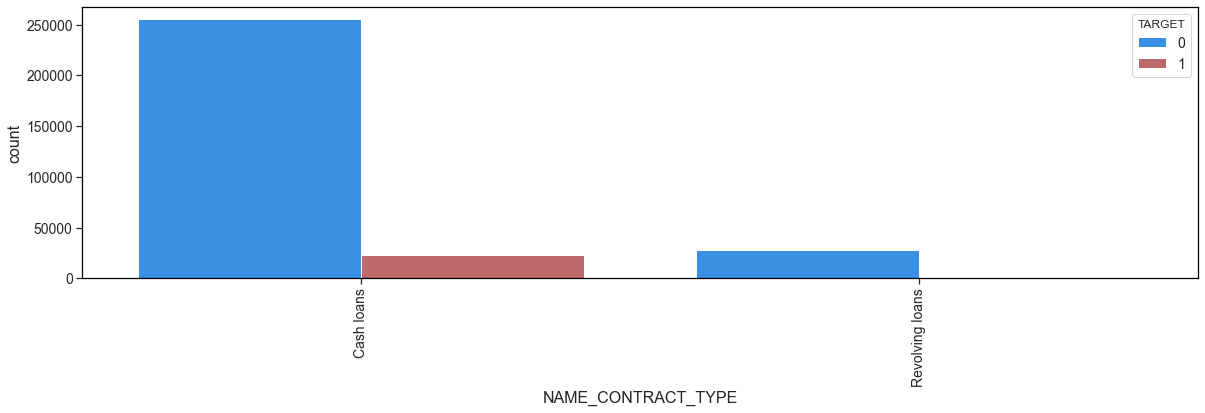

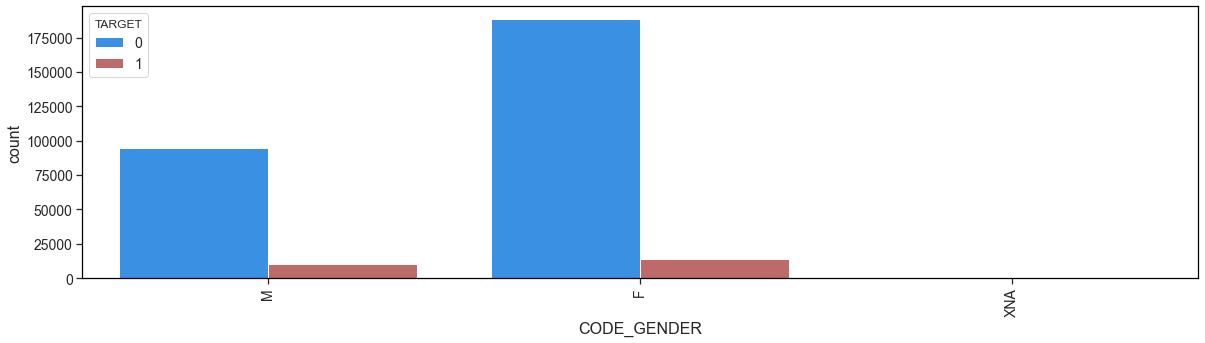

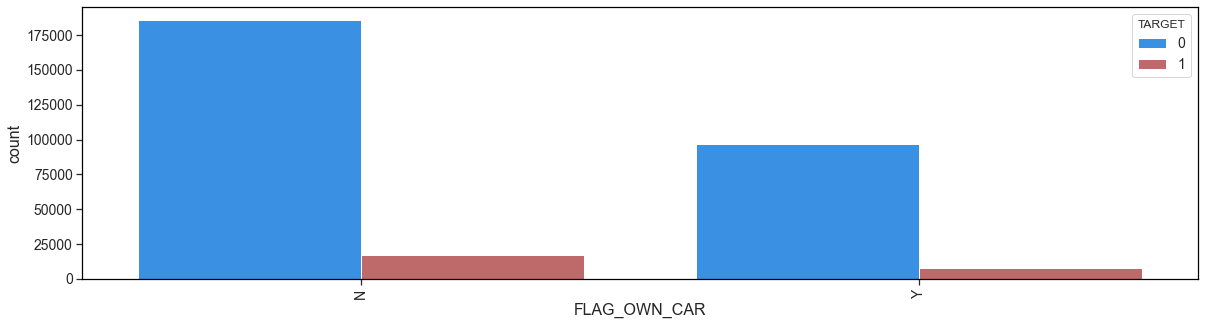

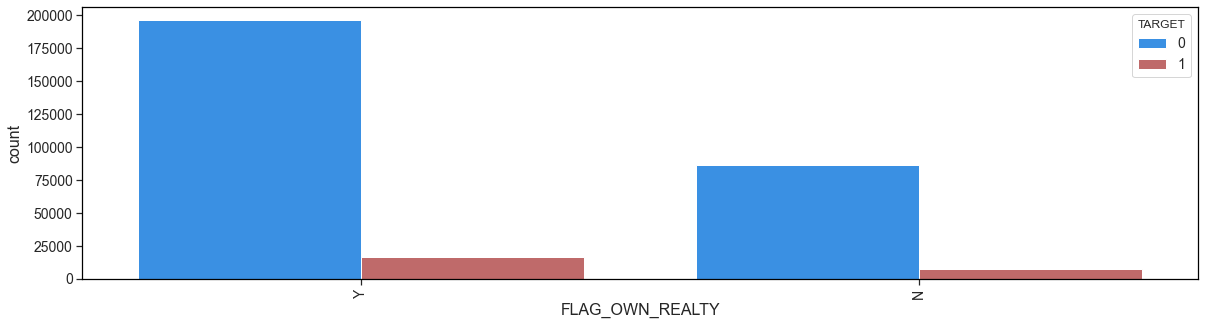

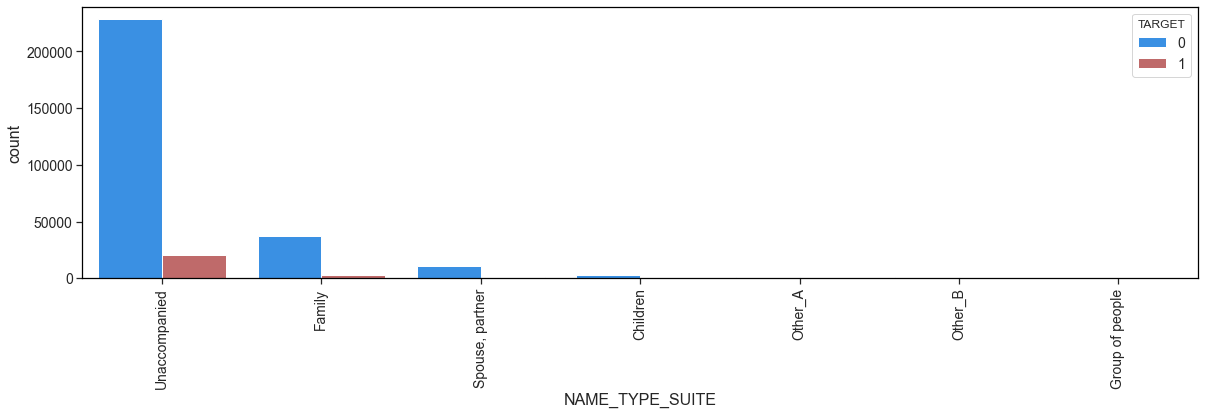

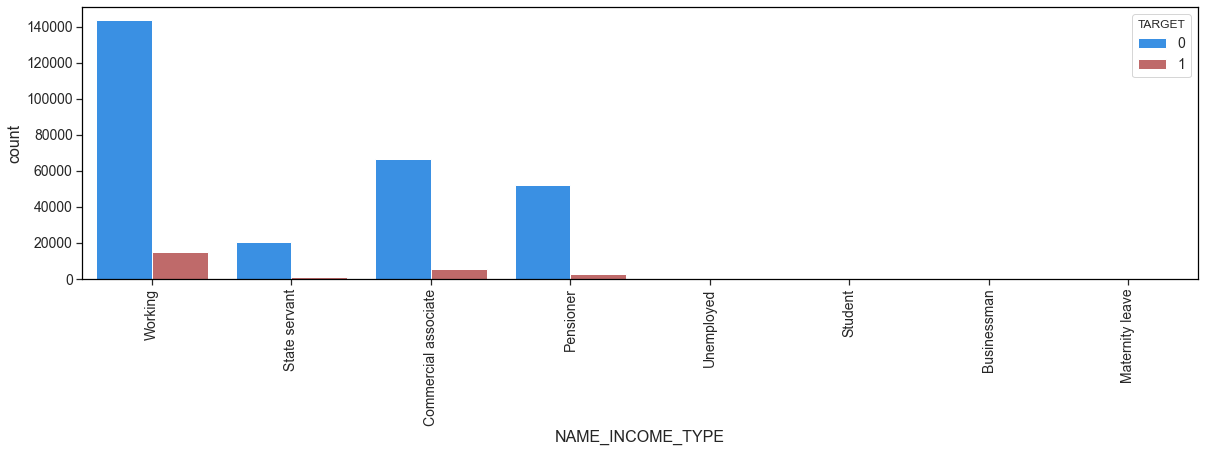

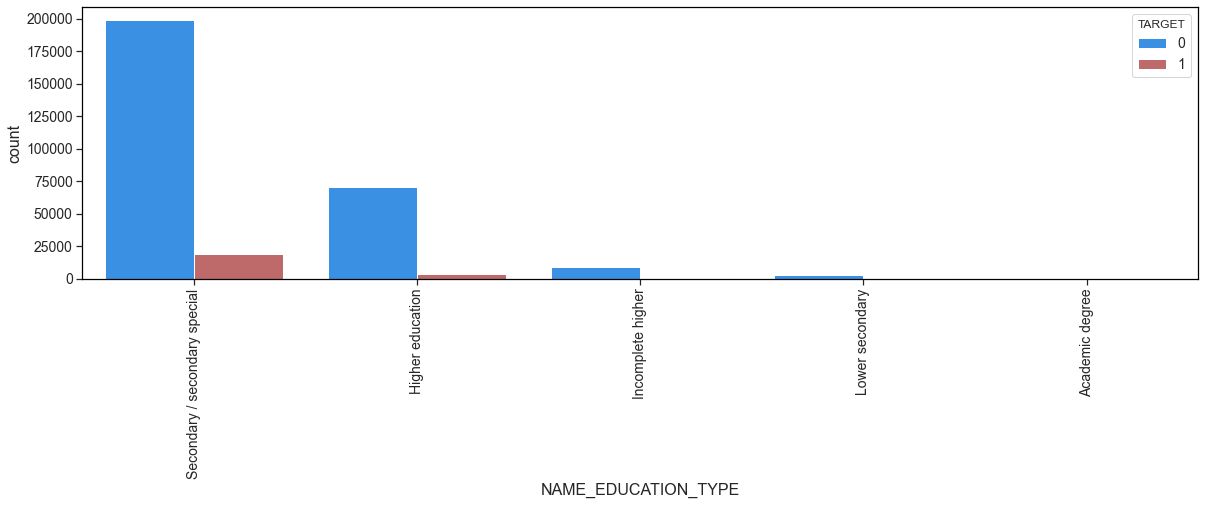

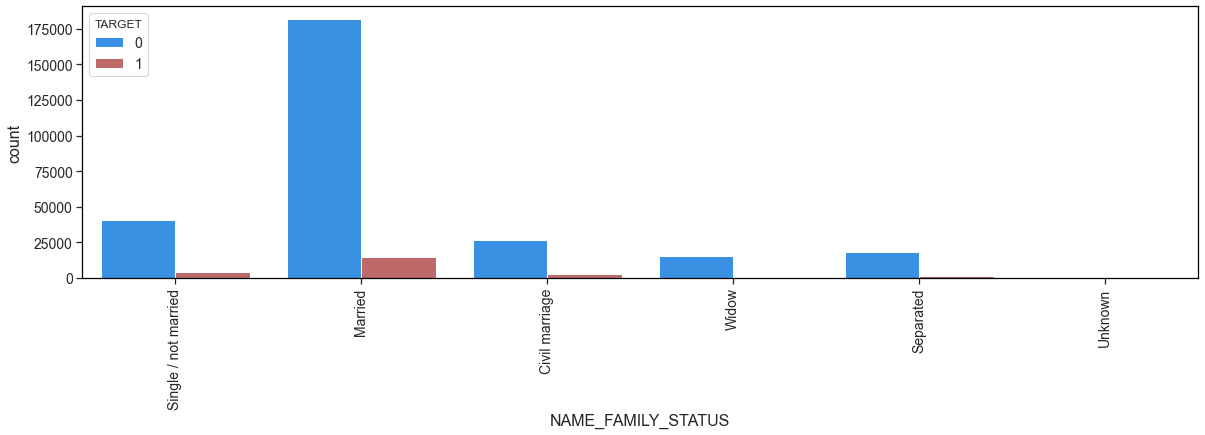

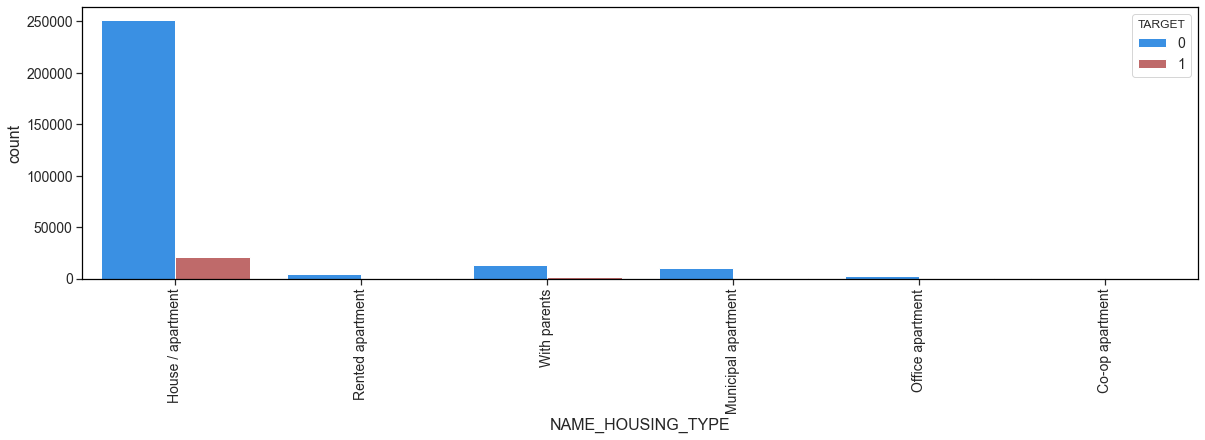

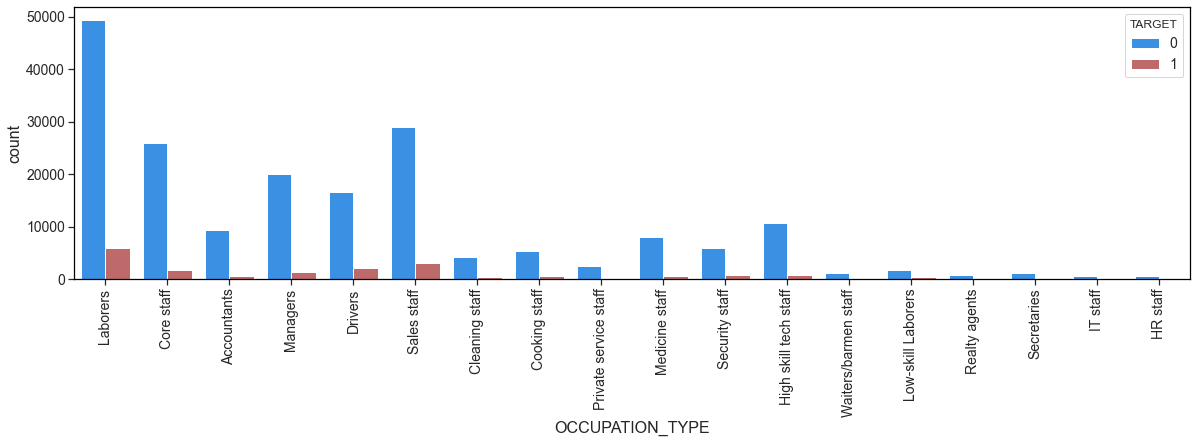

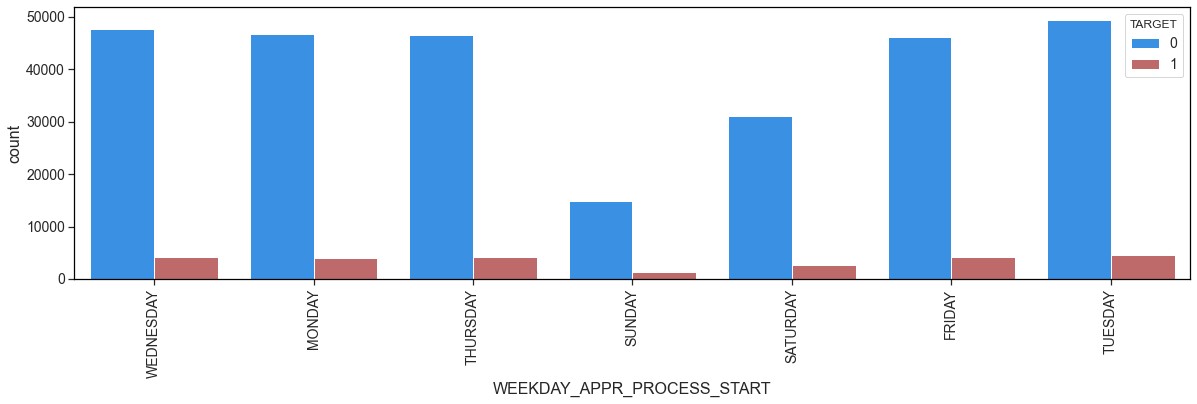

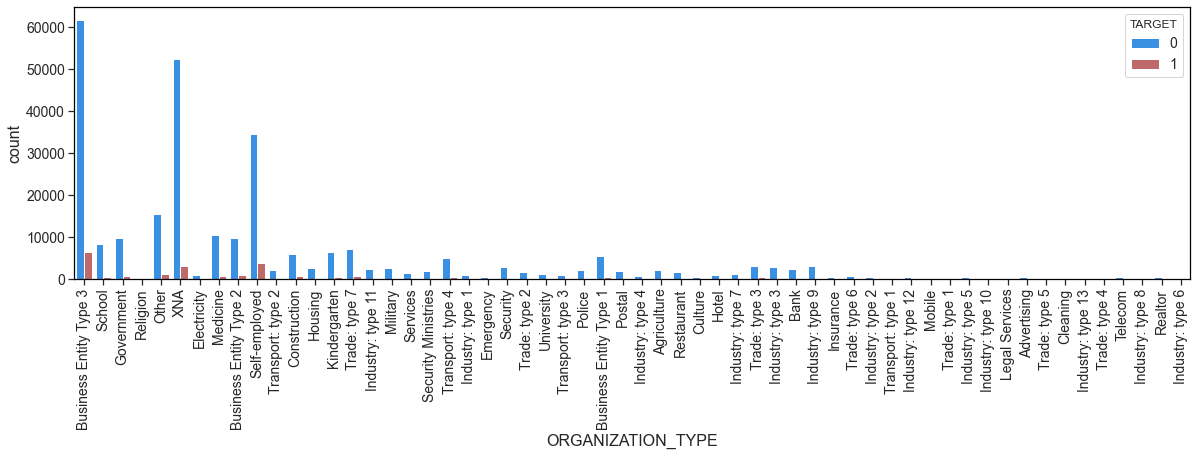

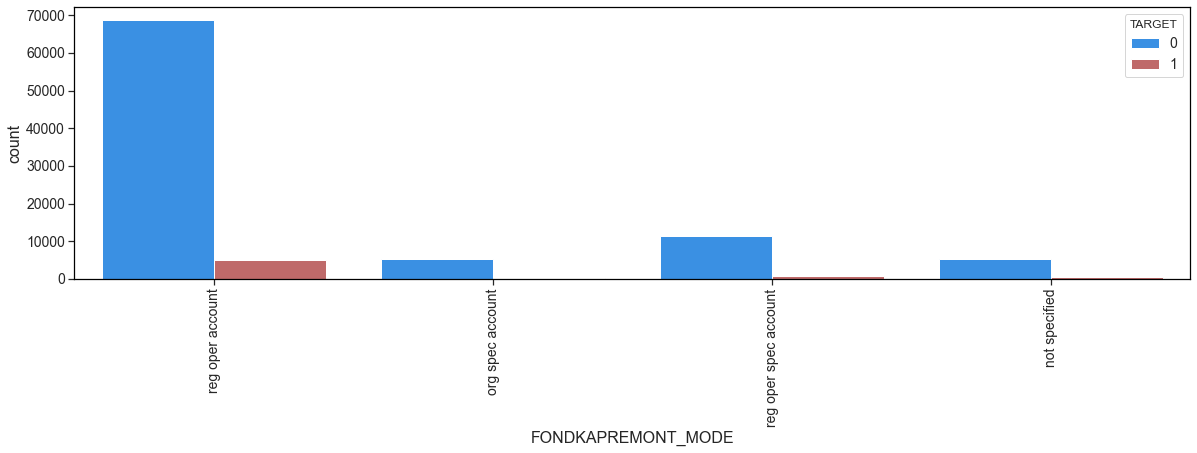

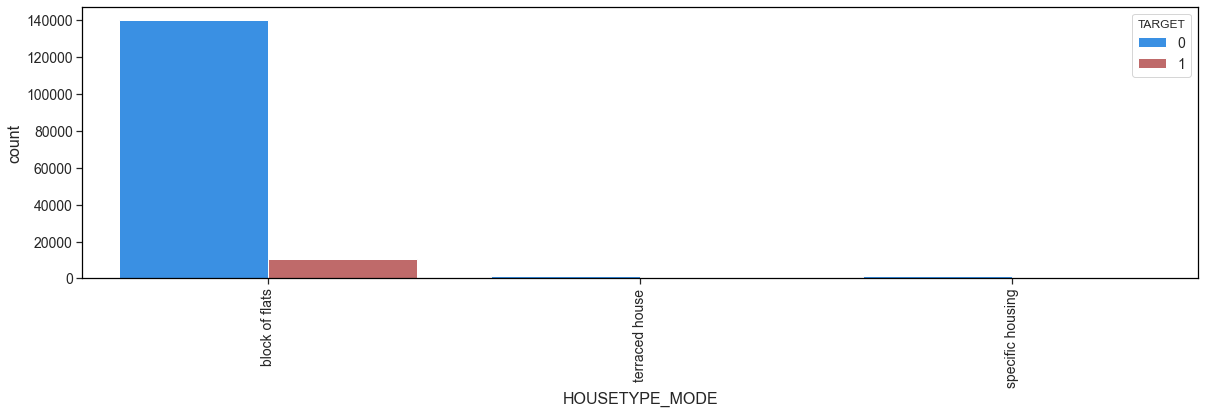

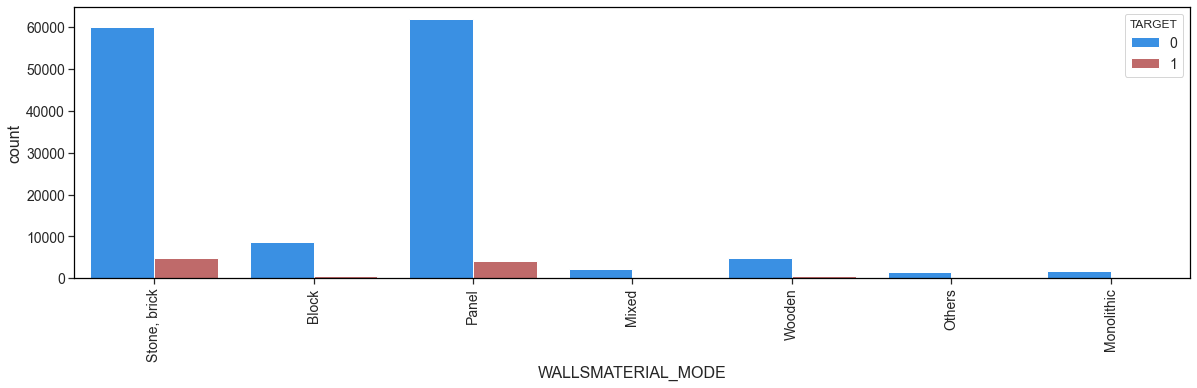

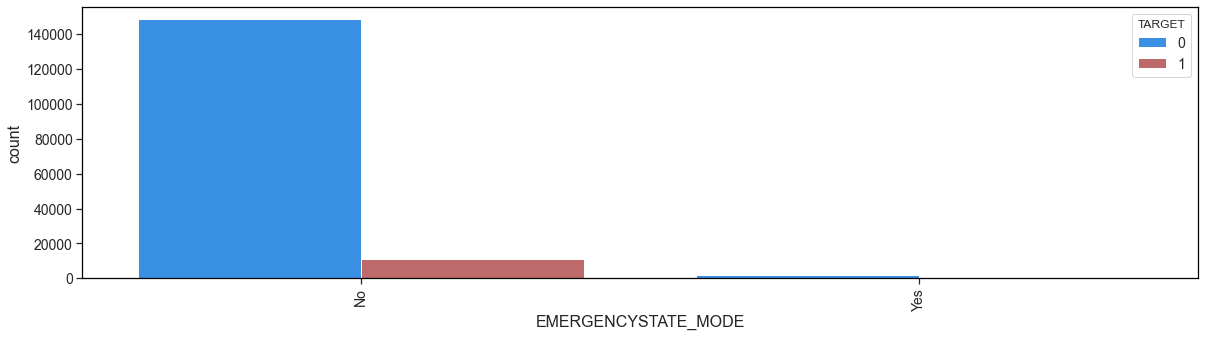

In [20]:
for col in cat_col:
    plt.figure(figsize=(20,5))
    sns.countplot(data=df, x=col, hue="TARGET", palette=color_bg)
    plt.xticks(rotation=90)
    plt.show()


We use Cramer's V statistics to evaluate the association between target and each feature.

Cramér’s V statistic is a commonly used measure of association between two categorical variables. It takes on values between 0 and 1 (inclusive), with 0 corresponding to no association between the variables and 1 corresponding to one variable being completely determined by the other.
https://statisticaloddsandends.wordpress.com/2020/02/22/what-is-cramers-v-statistic/#:~:text=Cram%C3%A9r's%20V%20statistic%20is%20a,completely%20determined%20by%20the%20other.

In [21]:
def cramers_corrected_stat(x, y):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher, 
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result = -1
    if len(x.value_counts()) == 1:
        print("First variable is constant")
    elif len(y.value_counts()) == 1:
        print("Second variable is constant")
    else:
        conf_matrix = pd.crosstab(x, y)

        if conf_matrix.shape[0] == 2:
            correct = False
        else:
            correct = True

        chi2 = stats.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r, k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return round(result, 2)

A general poor association is observed (V < 0.1). OCCUPATION_TYPE and ORGANIZATION_TYPE are the most associated.

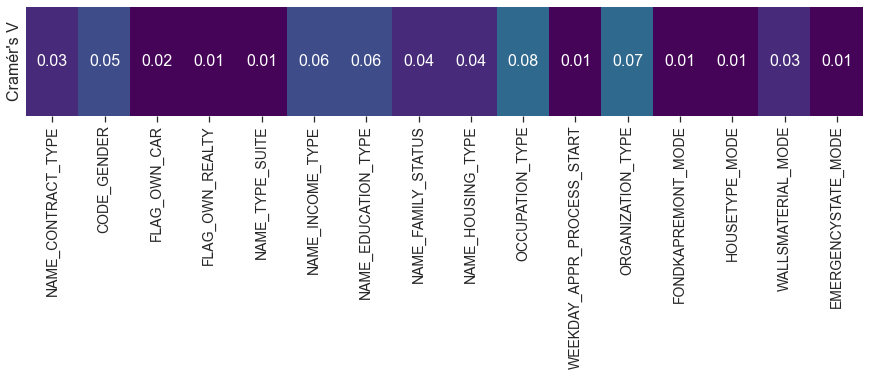

In [22]:
cramers_tab = pd.DataFrame(np.ones((1, len(cat_col)), dtype=float))

cramers_tab.columns = cat_col
cramers_tab.index = ["TARGET"]

for col in cat_col:
    phi = cramers_corrected_stat(df["TARGET"], df[col])
    cramers_tab.loc["TARGET", col] = phi
    
plt.figure(figsize=(15, 2))
sns.heatmap(cramers_tab, annot=True, cmap=my_colors(10)[:4], cbar=False)
plt.ylabel('Cramér\'s V')
plt.yticks([])
plt.show()

### Bivariate analysis num/num features

We've been focused on target. That's good but now let's go a step further and analyze relationships between each num features.

First, I notice that a bunch of features were the same but with different aggregation metrics (_AVG, _MEDI and _MODE). To simplify a bit, let's get rid of the two latters.

Then, plotting corr heatmaps (abs values of Pearson's coef).

In [23]:
df_num = df.select_dtypes(np.number)

for col in df_num.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        df_num.drop(columns=col, inplace=True)

D:\Python\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


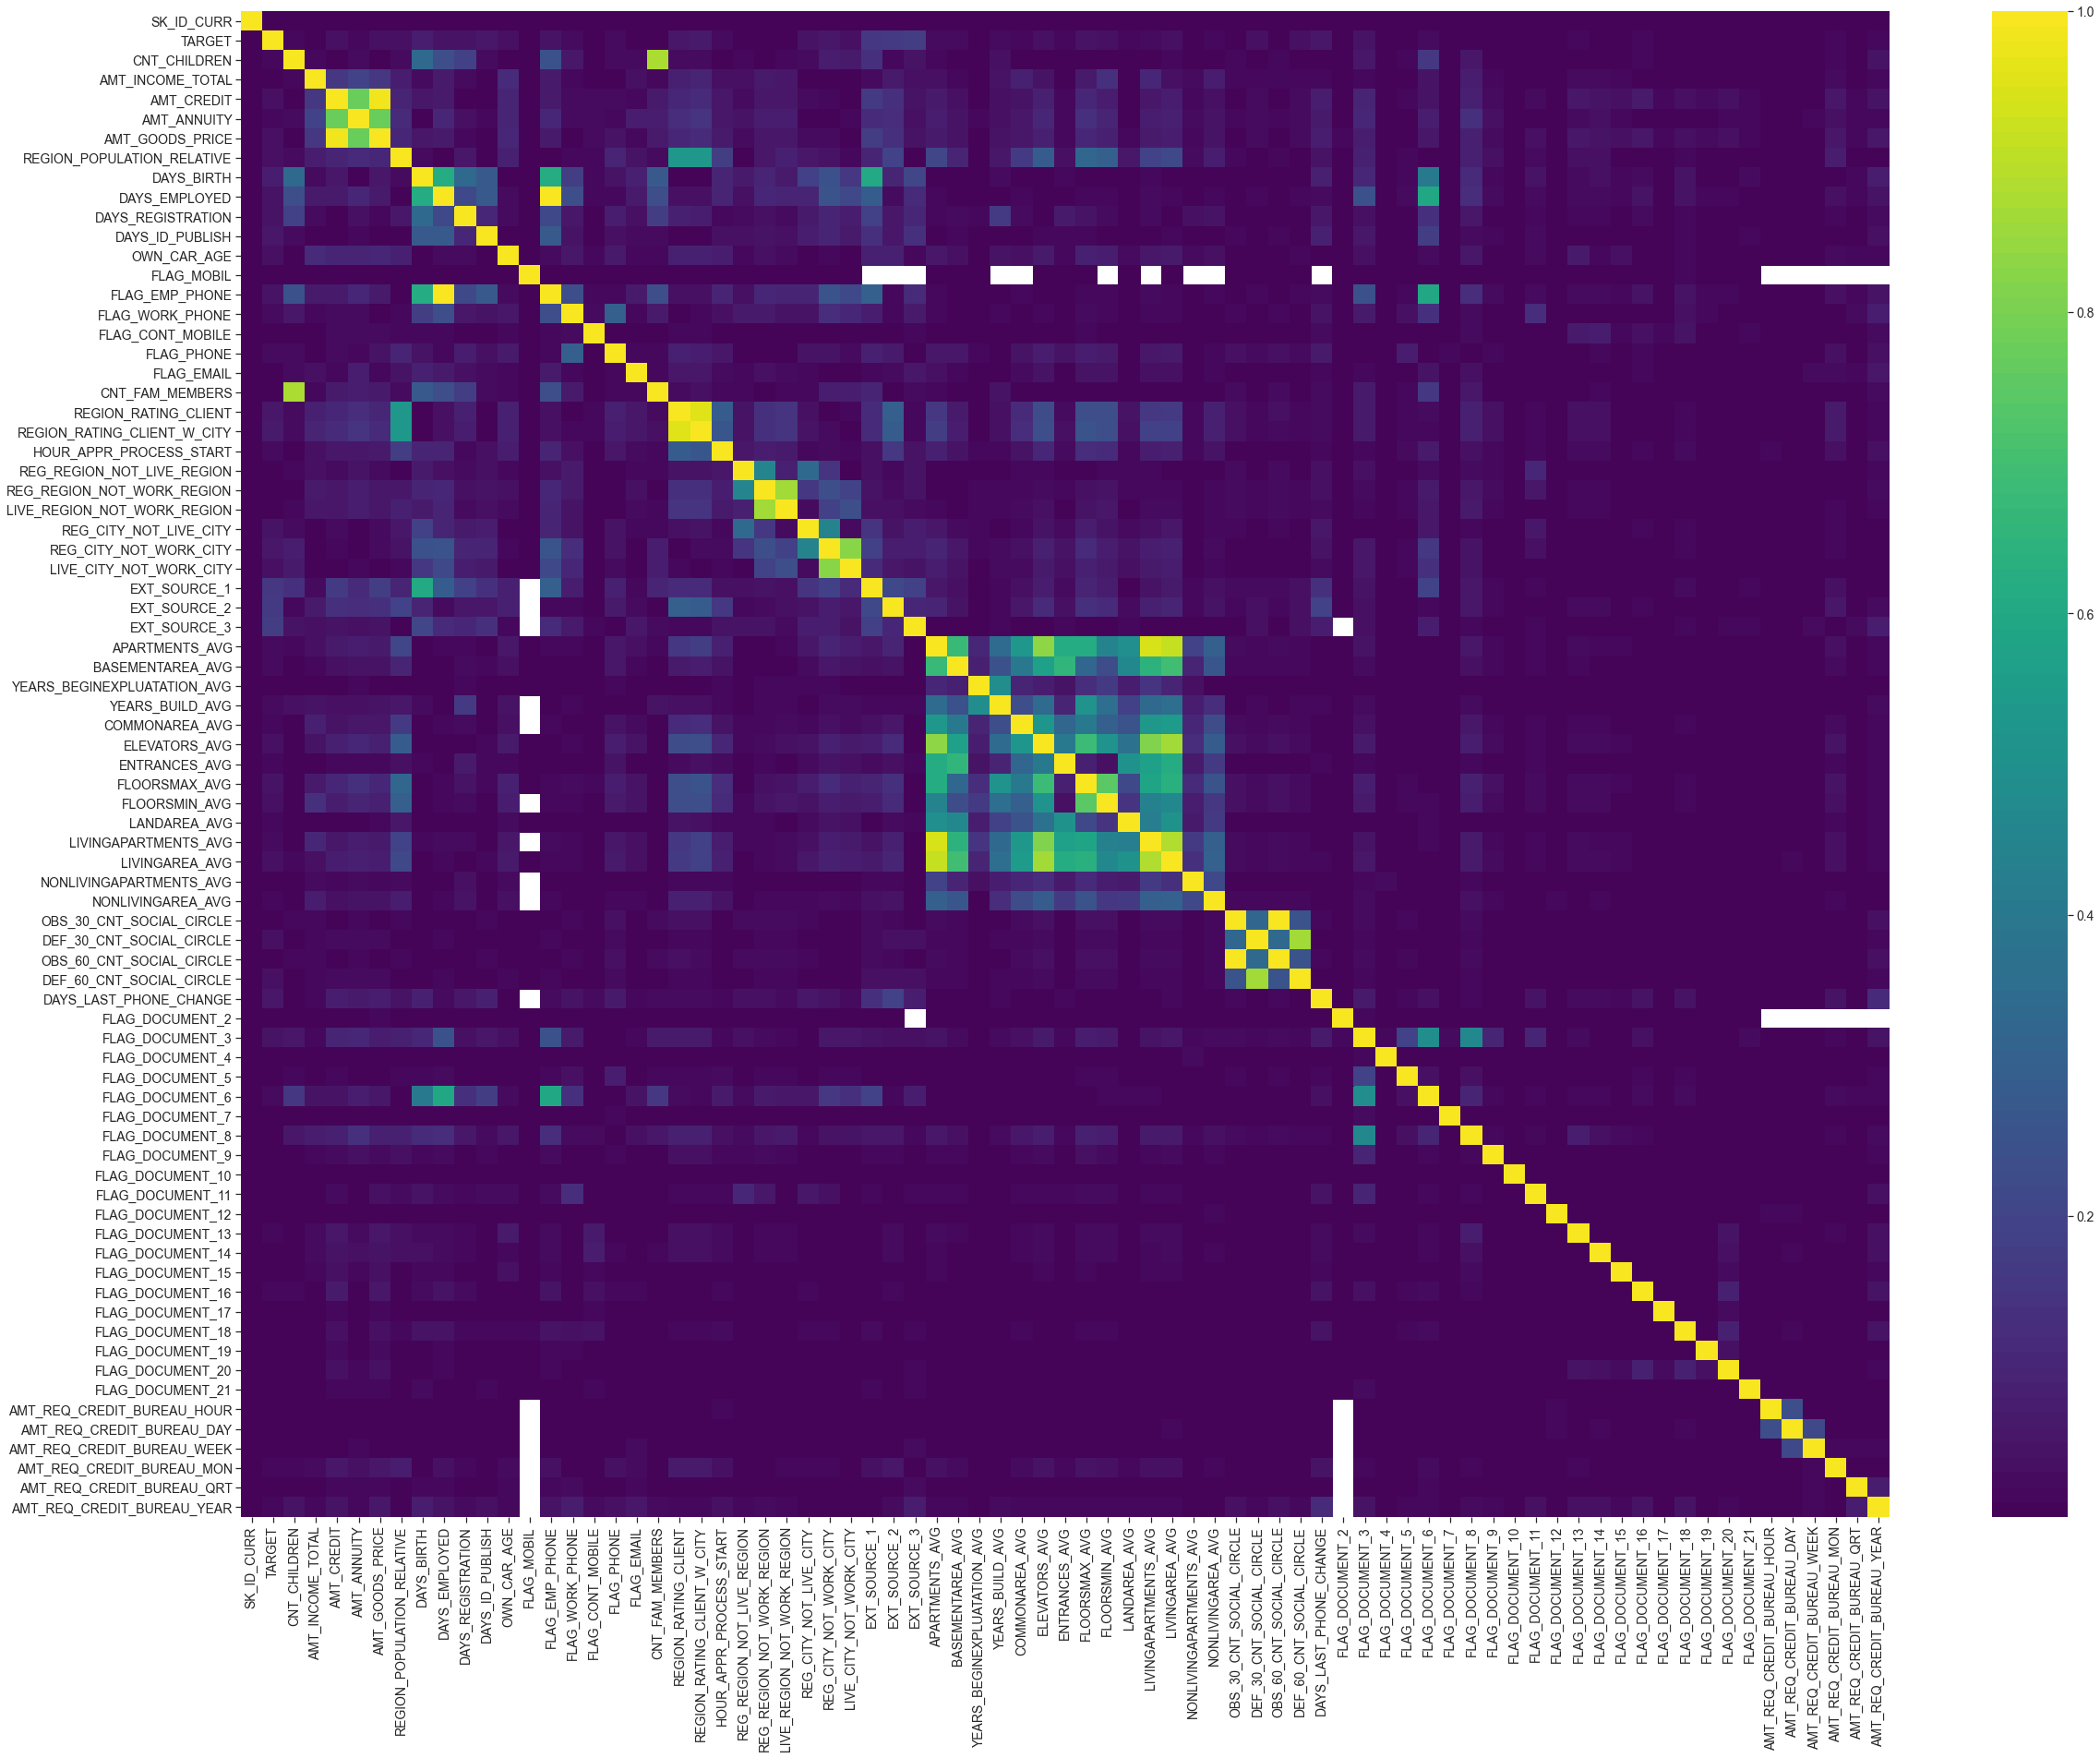

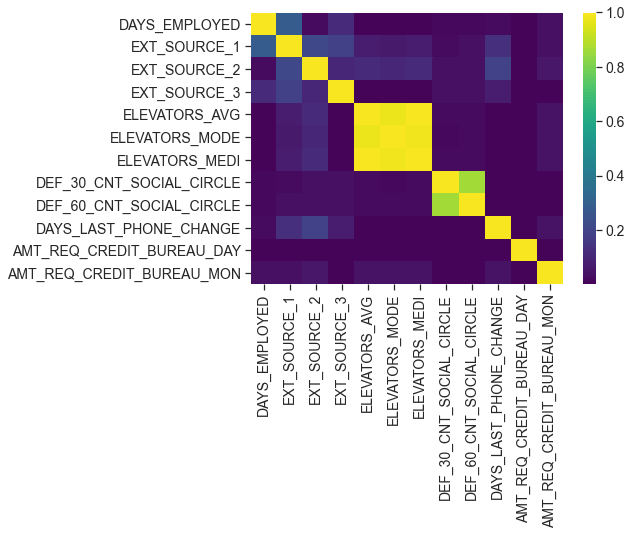

In [24]:
plt.figure(figsize=(40,30))
sns.heatmap(np.abs(df_num.corr()), cmap=my_colors(100));
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(np.abs(df[interest_col].corr()), cmap=my_colors(100));
plt.show()

Exctracting and ranking correlating features, by Pearson's.

In [25]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_neg_correlations(df, n=5):
    au_corr = df.corr()[df.corr() < 0].unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]


def get_top_pos_correlations(df, n=5):
    au_corr = df.corr()[df.corr() > 0].unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


top_neg_corr = get_top_neg_correlations(df_num, 20)
top_pos_corr = get_top_pos_correlations(df_num, 150)

print("Top Negative Correlations")
display(HTML(pd.DataFrame(top_neg_corr).to_html()))
print("\n")
print("Top Positive Correlations")
display(HTML(pd.DataFrame(top_pos_corr).to_html()))

Top Negative Correlations




Top Positive Correlations


# Modelling


Within this approach we'll do a basic and gross cleaning using some inputer, to evaluate the feature importance to have a better lead for performing a second, much finer data cleaning.

## Data preparation and train/test split

In [26]:
df_pay = df[df.TARGET == 0]
df_unpay = df[df.TARGET == 1]
print(f'Len TARGET == 0: {len(df_pay)} and Len TARGET == 1: {len(df_unpay)}')

Len TARGET == 0: 282686 and Len TARGET == 1: 24825


In [27]:
X = df.drop(columns=['SK_ID_CURR','TARGET'])
for col in X.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        X.drop(columns=col, inplace=True)

y = df['TARGET']

In [78]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

## Preprocessing
Num feats: simpe imputer (median, to handle NaNs) + standard scaler

Cat feats: one-hot-encoder

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Defining preprocessor
numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
                              )

categorical_features = X.select_dtypes(exclude=np.number).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)
                  ]
)

preprocessor.fit(X_train)
# Want to fit 'num' on X_train[numeric_features] (to avoid info leakage)
preprocessor.named_transformers_['num'].fit(X_train[numeric_features]) # <-
# Want to fit 'cat' on X[categorical_features] (to avoid columns mismatch)
preprocessor.named_transformers_['cat'].fit(X[categorical_features])

# Transform X_train and X_test
X_train_sc = preprocessor.transform(X_train)
X_test_sc = preprocessor.transform(X_test)




##### Model optimization using randomized cross-validation
- Different gradient boosting models were tested (see below))
- Only LightGBM provided with sufficient low CPU times
- Using AUC-ROC scoring as it was the score of the Kaggle competition
- Using Random CV rather than Grid CV due to the large number of hyperparams
- CV using 3 stratified folds

#### Train 

In [30]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

n = 10
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      scale_pos_weight=weight,
                      )
#max_depth (int, optional (default=-1)) – Maximum tree depth for base learners, <=0 means no limit.
#random_state random_state – Random number seed.
#silent (bool, optional (default=True)) – Whether to print messages while running boosting.
#n_jobs (int, optional (default=-1)) – Number of parallel threads to use for training (can be changed at prediction time).
#n_estimators (int, optional (default=100)) – Number of boosted trees to fit.
#class_weight– Weights associated with classes in the form {class_label: weight}.
#for binary classification task you may use is_unbalance or scale_pos_weight

lgbm_param = {'num_leaves': np.linspace(10, 80, 7, dtype='int'),
              'min_child_samples': stats.randint(100, 500),
              'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
              'subsample': stats.uniform(loc=0.2, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

#num_leaves (int, optional (default=31)) – Maximum tree leaves for base learners.
#min_child_samples (int, optional (default=20)) – Minimum number of data needed in a child (leaf)
#min_child_weight (float, optional (default=1e-3)) – Minimum sum of instance weight (hessian) needed in a child (leaf).
#subsample (float, optional (default=1.)) – Subsample ratio of the training instance.
#colsample_bytree (float, optional (default=1.)) – Subsample ratio of columns when constructing each tree.
#reg_alpha (float, optional (default=0.)) – L1 regularization term on weights.
#reg_lambda (float, optional (default=0.)) – L2 regularization term on weights.

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

#n_iter Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#scoring: Strategy to evaluate the performance of the cross-validated model on the test set.
#cv: Determines the cross-validation splitting strategy.
#n_jobs:Number of jobs to run in parallel -1 means using all processors. 
#verboseint Controls the verbosity: the higher, the more messages.
#random_state Pseudo random number generator state used for random uniform sampling from lists of possible values instead of scipy.stats distributions  Pass an int for reproducible output across multiple function calls

#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli

grid_result=grid.fit(X_train_sc, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)
optima = pd.DataFrame(grid.cv_results_).T
optima

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.758
{'colsample_bytree': 0.5790696825335077, 'min_child_samples': 260, 'min_child_weight': 100.0, 'num_leaves': 68, 'reg_alpha': 100, 'reg_lambda': 50, 'subsample': 0.5976042668810364}


0  \
mean_fit_time                                                      39.0693   
std_fit_time                                                       2.32735   
mean_score_time                                                    5.26258   
std_score_time                                                    0.166588   
param_colsample_bytree                                            0.866621   
param_min_child_samples                                                174   
param_min_child_weight                                               1e-05   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                       100   
param_subsample                                                   0.343323   
params                   {'colsample_bytree': 0.8666214463442921, 'min_...   
split0_test_score                                                 0.755065   
split1_test_score                                                 0.761405   
split2_test_score                                                 0.749477   
mean_test_score                                                   0.755316   
std_test_score                                                   0.0048725   
rank_test_score                                                          5   

                                                                         1  \
mean_fit_time                                                      36.3289   
std_fit_time                                                      0.953608   
mean_score_time                                                    6.13093   
std_score_time                                                    0.551553   
param_colsample_bytree                                             0.85515   
param_min_child_samples                                                344   
param_min_child_weight                                                   1   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                        10   
param_subsample                                                   0.228029   
params                   {'colsample_bytree': 0.8551504021292146, 'min_...   
split0_test_score                                                 0.754062   
split1_test_score                                                 0.760139   
split2_test_score                                                 0.746188   
mean_test_score                                                   0.753463   
std_test_score                                                   0.0057111   
rank_test_score                                                          8   

                                                                         2  \
mean_fit_time                                                      37.0906   
std_fit_time                                                      0.735641   
mean_score_time                                                    5.37295   
std_score_time                                                    0.292226   
param_colsample_bytree                                             0.57907   
param_min_child_samples                                                260   
param_min_child_weight                                                 100   
param_num_leaves                                                        68   
param_reg_alpha                                                        100   
param_reg_lambda                                                        50   
param_subsample                                                   0.597604   
params                   {'colsample_bytree': 0.5790696825335077, 'min_...   
split0_test_score                                                 0.757884   
split1_test_sco

In [31]:
import joblib
joblib.dump(grid.best_estimator_, 'model.pkl', compress = 1)

['model.pkl']

In [32]:
# load the model from disk
loaded_model = joblib.load('model.pkl')
result = loaded_model.score(X_test_sc, y_test)
print(result)

0.7199323610230395


#### Selecting best estimator and plotting results on test sets

TN = 39185, FP = 17382, FN = 1531, TP = 3405
Testset: threshold = 47%, G-Mean= 69%, AUC = 69%, Precision = 16%, recall= 69%, f1 = 26%


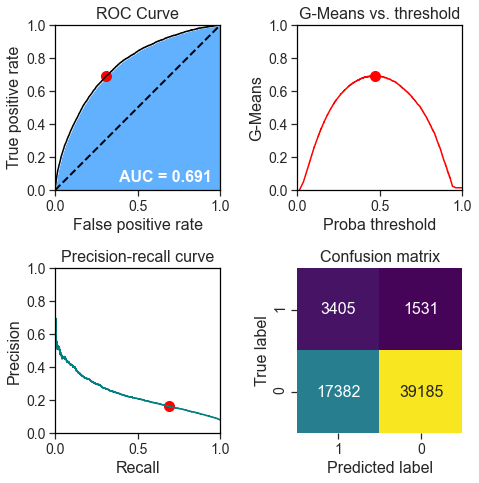

In [33]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

model = grid.best_estimator_
model.fit(X_train_sc, y_train)

y_prob = model.predict_proba(X_test_sc)
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
#g-mean is a performance metric that combines true negative rate and true positive rate at ‘one’ specific threshold 
#where both the errors are considered equal
#Le "Threshold" représente dans une classification binaire la probabilité que la prédiction soit vraie. 
#Il représente le compromis entre les faux positifs et les faux négatifs.

g_means = np.sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)

#auc is a performance metric that equals to the probability that a classifier will rank a randomly chosen positive instance
#higher than a randomly chosen negative one. Importantly, AUC is computed from a ROC which is plotted between true positive rate and false positive rate at various (theoretically all) thresholds.

#Le recall permet de savoir le pourcentage de positifs bien prédit par notre modèle.
#c’est le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs (Vrai Positif + Faux Négatif).
#Plus il est élevé, plus le modèle maximise le nombre de Vrai Positif.
#Néanmoins cela ne donne aucune information sur sa qualité de prédiction sur les négatifs.

#La precision permet de connaître le nombre de prédictions positifs bien effectuées.
#c’est le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit (Vrai Positif + Faux Positif).
#Plus elle est élevé, plus le modèle de minimise le nombre de Faux Positif.

#le F1 Score permet de combiner la precision et le recall existe et d’effectuer une bonne évaluation de la performance de notre modèle.
#plus le F1 Score est élevé, le plus votre modèle est performant.

######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
Precision = {precision:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

In [34]:
#train_data = lgb.Dataset('train.svm.txt')

#validation_data = train_data.create_valid('validation.svm')

#bst = lgb.train(lgbm_param, train_data, n, valid_sets=[validation_data])

Recovering Top 20 important features to decision

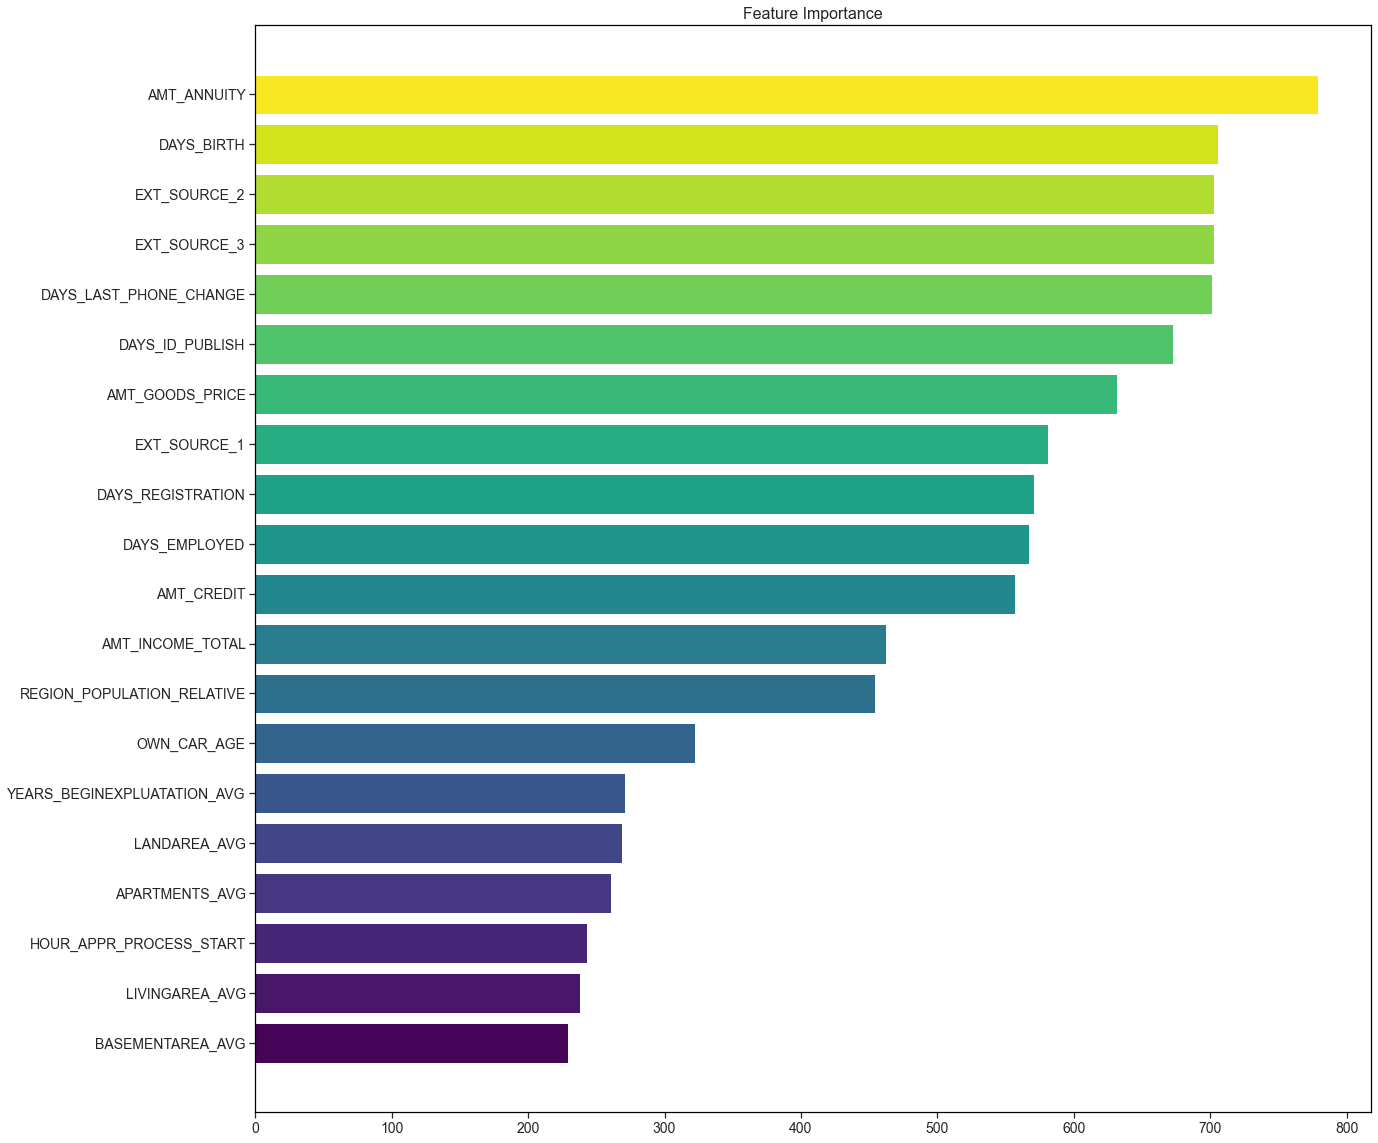

In [35]:
# Recover features columns (especially after OneHotEncoder)
onehot_columns = list(preprocessor.named_transformers_[
                      'cat'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
features_list = np.concatenate((numeric_features_list, onehot_columns))


# Recover important features from previous fit and then permute importance
n_feat = 20  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(20,20))
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center', color=my_colors(20))
plt.yticks(pos[-1*n_feat:], features_list[sorted_idx][-1*n_feat:])
plt.title('Feature Importance')
plt.show()

### shap

In [36]:
import shap 
# package used to calculate Shap values

In [37]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate Shap values
shap_values = explainer.shap_values(X_test_sc)

print ( "Valeur de base:" ,  explainer. expected_value ) 

Valeur de base: [0.5590022314315435, -0.5590022314315435]


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [38]:
# Recover features columns (especially after OneHotEncoder)
#onehot_columns = list(preprocessor.named_transformers_['cat'].get_feature_names(input_features=categorical_features))
#numeric_features_list = list(numeric_features)
#features_list = np.concatenate((numeric_features_list, onehot_columns))

In [84]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9930 entries, 284665 to 135323
Data columns (total 87 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   NAME_CONTRACT_TYPE           9930 non-null   object 
 1   CODE_GENDER                  9930 non-null   object 
 2   FLAG_OWN_CAR                 9930 non-null   object 
 3   FLAG_OWN_REALTY              9930 non-null   object 
 4   CNT_CHILDREN                 9930 non-null   int64  
 5   AMT_INCOME_TOTAL             9930 non-null   float64
 6   AMT_CREDIT                   9930 non-null   float64
 7   AMT_ANNUITY                  9930 non-null   float64
 8   AMT_GOODS_PRICE              9925 non-null   float64
 9   NAME_TYPE_SUITE              9900 non-null   object 
 10  NAME_INCOME_TYPE             9930 non-null   object 
 11  NAME_EDUCATION_TYPE          9930 non-null   object 
 12  NAME_FAMILY_STATUS           9930 non-null   object 
 13  NAME_HOUSIN

In [81]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values[1][0], feature_names=features_list)

Exception: Length of features is not equal to the length of shap_values!

In [47]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],
                shap_values[0][0])

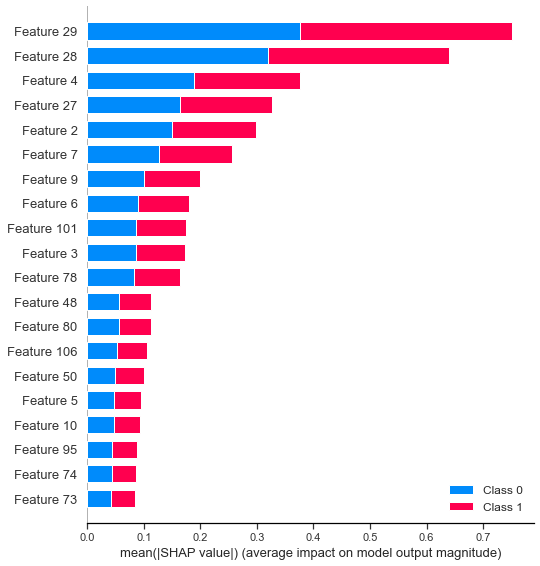

In [48]:
shap.summary_plot(shap_values)

## NON CONSERVE 

In [49]:

from sklearn.metrics import SCORERS

SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [51]:
###############################################
#  Tested_model but too long or not efficient
###############################################
gbc = GradientBoostingClassifier(n_estimators=100, max_features=None, random_state=13)
gbc_grid = {'n_estimators': [300], 'learning_rate': [0.6],'subsample': [1]}
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, 
objective='binary:logistic', silent=True, nthread=1, )
xgb_params = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],
              'subsample': [0.6, 0.8, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 4, 5]}
###############################################

In [52]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

n = 25
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      scale_pos_weight=weight,
                      )

scoring = ['roc_auc','precision','recall','f1']

x_val = cross_validate(lgbm,
                        X_train_sc,
                        y_train,
                        cv=3,
                        scoring=scoring)

In [53]:

pd.DataFrame(x_val).mean(axis=0)

fit_time          2.812123
score_time        0.576457
test_roc_auc      0.753251
test_precision    0.173183
test_recall       0.640655
test_f1           0.272656
dtype: float64

In [54]:
time, unk, auc, precision, recall, f1 = pd.DataFrame(x_val).mean(axis=0)

### LightGBM with prior class balancing

In [55]:
df_samp = df.copy()
df_samp = df_samp[df_samp['TARGET'] == 0].sample(len(df_unpay))
df_samp_concat = pd.concat([df_unpay, df_samp], axis=0)
df_samp_concat.shape

(49650, 122)

In [56]:
X = df_samp_concat.drop(columns=['SK_ID_CURR','TARGET'])
for col in X.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        X.drop(columns=col, inplace=True)

y = df_samp_concat['TARGET']

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
                              )

categorical_features = X.select_dtypes(exclude=np.number).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)
                  ]
)

In [59]:
preprocessor.fit(X_train)
X_train_sc = preprocessor.transform(X_train)
X_test_sc = preprocessor.transform(X_test)

In [60]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

n = 10
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      #scale_pos_weight=weight,
                      )

lgbm_param = {'num_leaves': np.linspace(10,80,7, dtype='int'),
              'min_child_samples': stats.randint(100, 500),
              'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
              'subsample': stats.uniform(loc=0.2, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train_sc, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='None', n_estimators=200,
                                            random_state=13),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002843A318430>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002843A2DF910>,
                                        'min_child_weight': [1e-05, 0.01, 1,
                                                             100.0, 10000.0],
                                        'num_leaves': array([10, 21, 33, 45, 56, 68, 80]),
                                        'reg_alpha': [0.1, 1, 10, 100],
                                        'reg_lambda': [0.1, 1, 10, 50, 100],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002843A3181C0>},
        

In [61]:
gc.collect()

7271

In [62]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

model = grid.best_estimator_
model.fit(X_train_sc, y_train)

y_prob = model.predict_proba(X_test_sc)
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)

TN = 3505, FP = 1462, FN = 1609, TP = 3354


Testset: threshold = 50%, G-Mean= 69%, AUC = 69%, recall= 68%, f1 = 69%


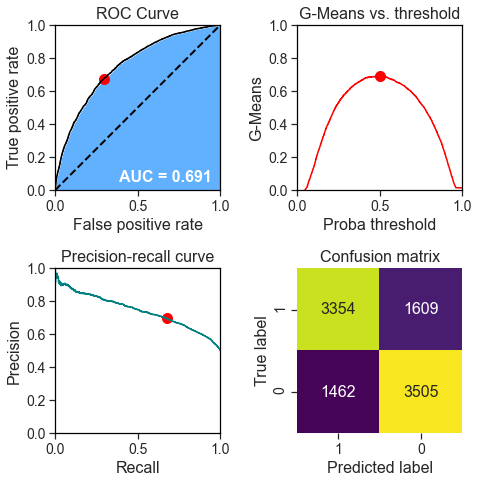

In [63]:
######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

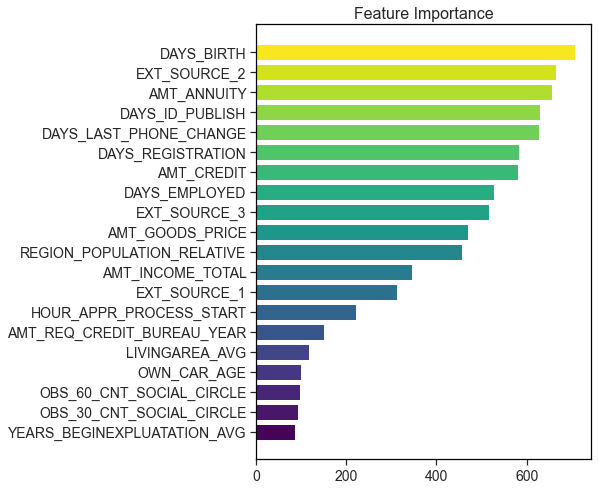

In [64]:
from sklearn.inspection import permutation_importance

# Recover features columns (especially after OneHotEncoder)
onehot_columns = list(preprocessor.named_transformers_[
                      'cat'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
features_list = np.concatenate((numeric_features_list, onehot_columns))

# Recover important features from previous fit and then permute importance
n_feat = 20  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6, 8))
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center', color=my_colors(20))
plt.yticks(pos[-1*n_feat:], features_list[sorted_idx][-1*n_feat:])
plt.title('Feature Importance')
plt.show()



### t-SVD+LGBM

In [65]:
df_samp = df.copy()
df_samp = df_samp[df_samp['TARGET'] == 0].sample(len(df_unpay))
df_samp_concat = pd.concat([df_unpay, df_samp], axis=0)
df_samp_concat.shape

(49650, 122)

In [66]:
X = df_samp_concat.drop(columns=['SK_ID_CURR','TARGET'])
for col in X.columns:
    if col.endswith("_MEDI") or col.endswith("_MODE"):
        X.drop(columns=col, inplace=True)

y = df_samp_concat['TARGET']

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

numeric_features = X.select_dtypes(include=np.number).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
                              )

categorical_features = X.select_dtypes(exclude=np.number).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)
                  ]
)

In [69]:
preprocessor.fit(X_train)
X_train_sc = preprocessor.transform(X_train)
X_test_sc = preprocessor.transform(X_test)

In [70]:
pd.DataFrame(X_train_sc)

0         1         2         3         4         5         6    \
0      0.764061  0.050558  1.747445  0.687884  1.644259 -0.771654  0.220490   
1      3.480420  0.020312 -0.088765 -0.528157 -0.187489  0.651261  0.391620   
2     -0.594118 -0.168727 -0.861983 -0.051561 -0.828601 -1.063782 -0.638867   
3      0.764061 -0.085550 -0.780593 -0.560236 -0.841685 -0.433167  0.528478   
4     -0.594118  0.095927  0.396303 -0.394933  0.270448  3.999857 -0.573796   
...         ...       ...       ...       ...       ...       ...       ...   
39715 -0.594118  0.133735 -0.088765 -0.094442 -0.187489 -0.079023 -0.382056   
39716  0.764061 -0.168727  0.696803 -0.154016  0.545210 -0.700321  0.153566   
39717  0.764061  0.058119  1.797517  1.076100  1.775098  0.854873 -0.372561   
39718 -0.594118 -0.168727 -0.663787 -0.900007 -0.671594 -0.921651 -1.217097   
39719 -0.594118  0.163966 -0.749059 -1.027013 -0.841685  3.999857  0.066496   

            7         8         9    ...  188  189  190  191  192  193  194  \
0     -0.420431  0.956623 -1.273872  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     -0.449898  0.636448  0.070615  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     -0.410439  0.709414  0.710597  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     -0.423940 -0.548520  0.359660  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     -0.411596 -1.912985  0.898245  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
39715 -0.407152 -0.104595  1.609994  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39716 -0.418628  0.397703 -1.291650  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39717 -0.406459  0.564065  1.467776  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39718  2.374586 -2.299413 -0.695782  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
39719 -0.408742  0.374354 -1.532630  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       195  196  197  
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
...    ...  ...  ...  
39715  0.0  1.0  0.0  
39716  0.0  0.0  0.0  
39717  0.0  0.0  0.0  
39718  0.0  0.0  1.0  
39719  0.0  0.0  0.0  

[39720 rows x 198 columns]

67


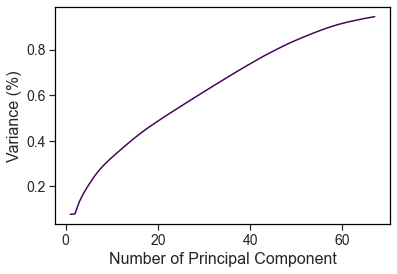

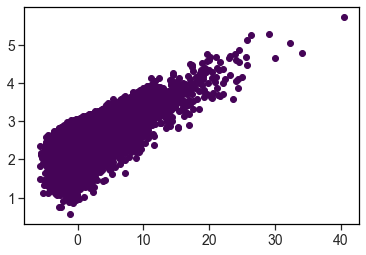

In [71]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(67, n_iter=10)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
print(len(pca.explained_variance_ratio_))
variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.linspace(1,len(variance),len(variance)), variance)
plt.xlabel('Number of Principal Component')
plt.ylabel('Variance (%)')
plt.show()

plt.scatter(X_train_pca[:,0], X_train_pca[:,1])
plt.show()

In [72]:
X_train_pca

array([[-0.54020106,  2.40441491,  0.79073596, ..., -0.5162783 ,
         0.83254371, -0.3835767 ],
       [-0.62154696,  1.92921102,  1.99375174, ..., -0.24619115,
        -0.60360381, -0.72803686],
       [-0.84658772,  2.83505713, -0.0059123 , ...,  0.23905893,
         0.54183164, -0.04392571],
       ...,
       [ 4.56453421,  2.86036943,  1.20718596, ..., -0.11117203,
        -1.14099374, -0.28592382],
       [-0.98235179,  2.63868969, -5.86330997, ...,  0.23961654,
        -0.15349658, -0.19422987],
       [ 0.8311159 ,  2.15881985, -0.21598177, ...,  0.35981977,
        -0.26597681,  0.41778723]])

In [73]:
np.where(variance > 0.95)

(array([], dtype=int64),)

In [74]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

n = 10
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      #scale_pos_weight=weight,
                      )

lgbm_param = {'num_leaves': np.linspace(10,80,7, dtype='int'),
              'min_child_samples': stats.randint(100, 500),
              'min_child_weight': [1e-5, 1e-2, 1, 1e2, 1e4],
              'subsample': stats.uniform(loc=0.2, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

In [75]:
grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train_pca, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)
optima = pd.DataFrame(grid.cv_results_).T
optima

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0.732
{'colsample_bytree': 0.8634272558083348, 'min_child_samples': 241, 'min_child_weight': 100.0, 'num_leaves': 21, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.5975211387798383}


0  \
mean_fit_time                                                      11.0401   
std_fit_time                                                     0.0479326   
mean_score_time                                                   0.715089   
std_score_time                                                   0.0282555   
param_colsample_bytree                                            0.866621   
param_min_child_samples                                                174   
param_min_child_weight                                               1e-05   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                       100   
param_subsample                                                   0.343323   
params                   {'colsample_bytree': 0.8666214463442921, 'min_...   
split0_test_score                                                 0.731538   
split1_test_score                                                 0.729278   
split2_test_score                                                 0.730437   
mean_test_score                                                   0.730417   
std_test_score                                                   0.0009226   
rank_test_score                                                          3   

                                                                         1  \
mean_fit_time                                                      9.09432   
std_fit_time                                                     0.0312436   
mean_score_time                                                   0.648266   
std_score_time                                                   0.0078538   
param_colsample_bytree                                             0.85515   
param_min_child_samples                                                344   
param_min_child_weight                                                   1   
param_num_leaves                                                        80   
param_reg_alpha                                                         10   
param_reg_lambda                                                        10   
param_subsample                                                   0.228029   
params                   {'colsample_bytree': 0.8551504021292146, 'min_...   
split0_test_score                                                 0.730369   
split1_test_score                                                 0.727934   
split2_test_score                                                 0.729626   
mean_test_score                                                    0.72931   
std_test_score                                                    0.001019   
rank_test_score                                                          5   

                                                                         2  \
mean_fit_time                                                      2.81979   
std_fit_time                                                      0.235417   
mean_score_time                                                   0.362697   
std_score_time                                                   0.0512684   
param_colsample_bytree                                             0.57907   
param_min_child_samples                                                260   
param_min_child_weight                                                 100   
param_num_leaves                                                        68   
param_reg_alpha                                                        100   
param_reg_lambda                                                        50   
param_subsample                                                   0.597604   
params                   {'colsample_bytree': 0.5790696825335077, 'min_...   
split0_test_score                                                 0.729252   
split1_test_sco

TN = 3348, FP = 1619, FN = 1643, TP = 3320
Testset: threshold = 50%, G-Mean= 67%, AUC = 67%, recall= 67%, f1 = 67%


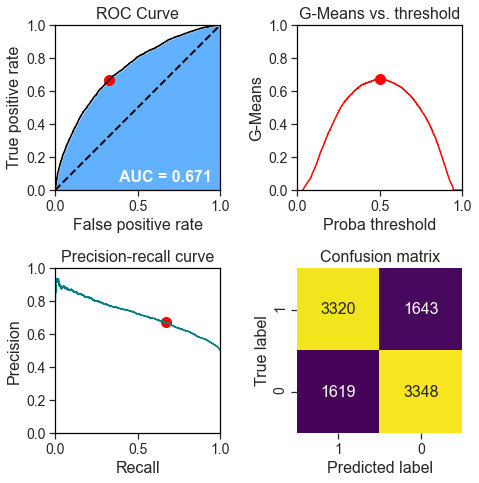

In [76]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

model = grid.best_estimator_
model.fit(X_train_pca, y_train)

y_prob = model.predict_proba(X_test_pca)
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(7, 7))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

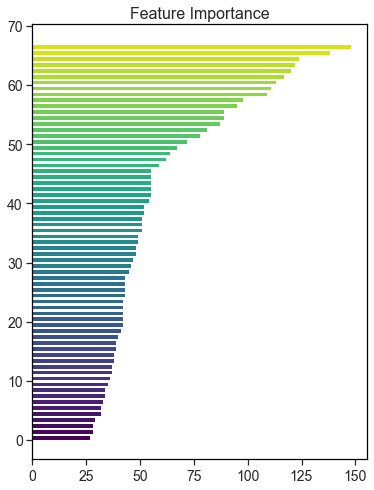

In [77]:
# Recover important features from previous fit and then permute importance
n_feat = 70  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6, 8))
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center', color=my_colors(70))
plt.title('Feature Importance')
plt.show()